# Problem Statement

Please find problem statement here:
https://datahack.analyticsvidhya.com/contest/job-a-thon/

Here, I have used `catboost` classifier for solving this problem. The rationale behind using catboost is that this dataset is having many categorical feature columns and catboost is very good in handling categorical data.

### Importing Dependancies

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', -1)

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler

from catboost import CatBoostClassifier

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


### Reading Dataset

In [2]:
# Reading and storing the training data as 'data'

data = pd.read_csv('train_Df64byy.csv')
# testset
data_t = pd.read_csv('test_YCcRUnU.csv')

print(data.shape)
data.head()

(50882, 14)


,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


It can be observed that the dataset is having 50882 entries (rows) and 14 columns. Columns also includes `Response` variable. This is a classification task.

In [3]:
# data overview

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  object 
 10  Holding_Policy_Type      30631 non-null  float64
 11  Reco_Policy_Cat          50882 non-null  int64  
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
dtypes: float64(2), int64(6

Observations,

- Dataset includes numeric (`int64`, `float64`) as well as `object` datatype columns.
- Some columns (`Health Indicator`, `Holding_Policy_Duration`, `Holding_Policy_Type`) are having null entries. We would specifically try to explore the reason behind it and convert them to non-null values.

## 1. Data Exploration and Understanding

#### 1.1 ID

In [4]:
# ID

data.ID.nunique()

50882

This is serialized ID column and wouldn't be useful in model building. Hence, we would be dropping it.

In [5]:
# Dropping 'ID' column

data = data.drop('ID', axis=1)

data.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


#### 1.2 City_Code

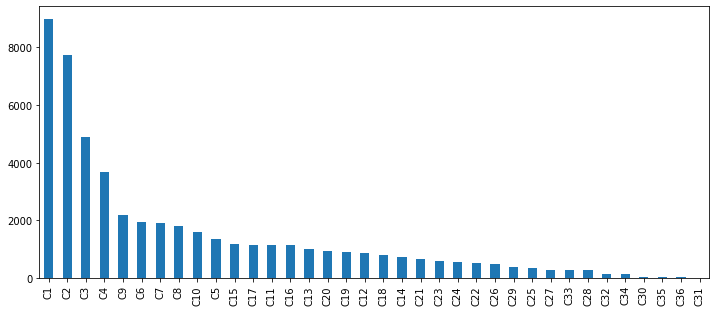

In [6]:
# City_Code

plt.subplots(figsize=(12,5))
data.City_Code.value_counts().plot.bar()
plt.show()

This column is having skewed distribution. Majot share of customers belong to C1 to C10.

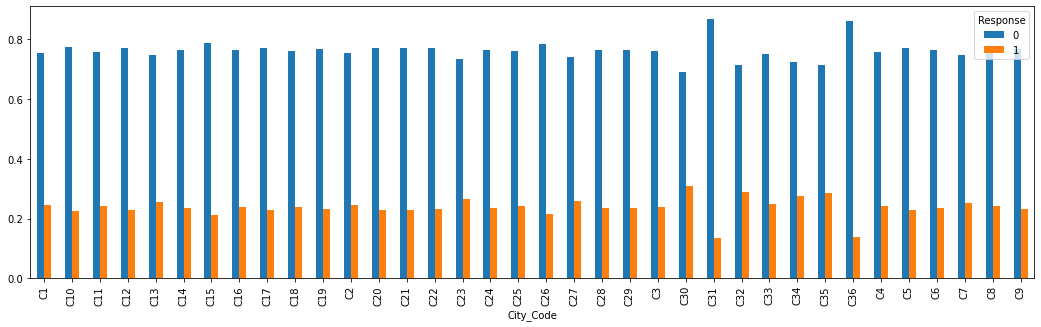

In [7]:
# City_Code Versus target variable (Response)

pd.crosstab(index=data.City_Code,
           columns=data.Response,
           normalize='index').plot.bar(figsize=(18, 5))
plt.show()

Majority of the customers haven't shown any interest towards recommended policy irrespective of the city code. Almost all the cities have similar response rate. Hence, it is difficult to classify using `City_Code` as feature. 

#### 1.3 Region_Code

In [8]:
# Region_Code

data.Region_Code.nunique()

5316

Customers belong to 5316 different regions. This column is having dtype as 'int64' but it is categorical in nature. There are lot many regions to consider hence we would be dropping this feature column.

In [9]:
data = data.drop('Region_Code', axis=1)
# test
data_t = data_t.drop('Region_Code', axis=1)

#### 1.4 Accomodation_Type

In [10]:
# Accomodation_Type

data.Accomodation_Type.value_counts()/data.shape[0]

Owned     0.54933
Rented    0.45067
Name: Accomodation_Type, dtype: float64

In [11]:
# Accomodation_Type Vs Response

pd.crosstab(index = data.Accomodation_Type,
            columns = data.Response,
            normalize='index')

Response,0,1
Accomodation_Type,,
Owned,0.758041,0.241959
Rented,0.762505,0.237495


It can be observed that,
- Customers owning (54.9%) the house are little more in count as compared to those who are renting (~45%). They both have fair share in total data.
- Response rate in both accommodation types have almost same response rate.

#### 1.5 Reco_Insurance_Type

In [12]:
# Reco_Insurance_Type

data.Reco_Insurance_Type.value_counts()

Individual    40536
Joint         10346
Name: Reco_Insurance_Type, dtype: int64

In [13]:
# Reco_Insurance_Type Vs Response

pd.crosstab(index = data.Reco_Insurance_Type,
            columns = data.Response,
            normalize='index')

Response,0,1
Reco_Insurance_Type,,
Individual,0.762187,0.237813
Joint,0.751691,0.248309


Observations,

- Majority (~80%) of the customers are recommended individual insurance type.
- Both recommendations have similar response rate.

#### 1.6 Upper_Age

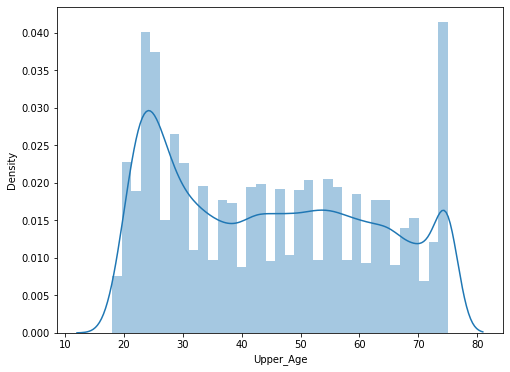

In [14]:
# Upper_Age

plt.subplots(figsize=(8, 6))
sns.distplot(data.Upper_Age)
plt.show()

#### 1.7 Lower_Age

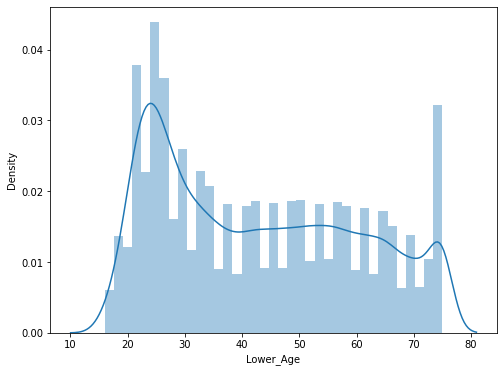

In [15]:
# Lower_Age

plt.subplots(figsize=(8, 6))
sns.distplot(data.Lower_Age)
plt.show()

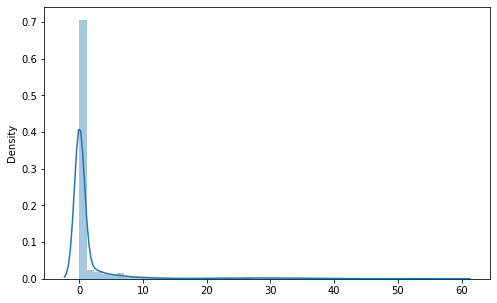

0    40536
1    1820 
2    1427 
3    1098 
4    774  
5    594  
6    475  
7    401  
8    277  
9    230  
dtype: int64


In [16]:
# Age Range

plt.subplots(figsize=(8, 5))
sns.distplot((data.Upper_Age - data.Lower_Age))
plt.show()

print((data.Upper_Age - data.Lower_Age).value_counts().head(10))

It indicates that most of the targets, which are offered insurance are individuals or with spouse with less age difference. 

#### 1.8 Is_Spouse

In [17]:
# Is_Spouse
pd.crosstab(index = data.Is_Spouse,
            columns = data.Response,
            normalize = 'index')

Response,0,1
Is_Spouse,,
No,0.760787,0.239213
Yes,0.756352,0.243648


`Is_Spouse` is not a feature to differentiate in response rate.

#### 1.9 Health_Indicator

X1     13010
NaN    11691
X2     10332
X3     6762 
X4     5743 
X5     1727 
X6     1280 
X7     196  
X8     78   
X9     63   
Name: Health Indicator, dtype: int64


<AxesSubplot:>

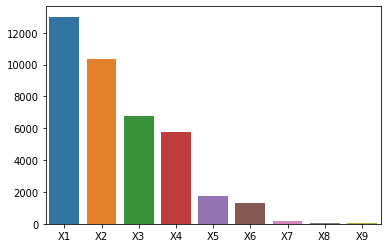

In [18]:
# Health Indicator

print(data['Health Indicator'].value_counts(dropna=False))

sns.barplot(x = data['Health Indicator'].value_counts(dropna=False).index,
            y = data['Health Indicator'].value_counts(dropna=False).values)

In [19]:
pd.crosstab(index = data['Health Indicator'],
            columns = data.Response,
            normalize = 'index')

Response,0,1
Health Indicator,,
X1,0.755880,0.244120
X2,0.758904,0.241096
X3,0.763531,0.236469
X4,0.756921,0.243079
X5,0.763752,0.236248
X6,0.760156,0.239844
X7,0.683673,0.316327
X8,0.769231,0.230769
X9,0.777778,0.222222


We can observe that people with Health Indicator type X7 have little better response rate as compared to other types.

#### 1.10 Holding_Policy_Duration

In [20]:
data.Holding_Policy_Duration.value_counts(dropna = False)

NaN     20251
1.0     4499 
14+     4335 
2.0     4260 
3.0     3586 
4.0     2771 
5.0     2362 
6.0     1894 
7.0     1645 
8.0     1316 
9.0     1114 
10.0    813  
11.0    546  
12.0    513  
13.0    511  
14.0    466  
Name: Holding_Policy_Duration, dtype: int64

In [21]:
pd.crosstab(index = data['Holding_Policy_Duration'],
            columns = data.Response,
            normalize = 'index')

Response,0,1
Holding_Policy_Duration,,
1.0,0.778395,0.221605
10.0,0.726937,0.273063
11.0,0.749084,0.250916
12.0,0.746589,0.253411
13.0,0.729941,0.270059
14+,0.749250,0.250750
14.0,0.753219,0.246781
2.0,0.762676,0.237324
3.0,0.767987,0.232013


#### 1.11 Holding_Policy_Type

In [22]:
data.Holding_Policy_Type.value_counts(dropna = False)

NaN    20251
3.0    13279
1.0    8173 
2.0    5005 
4.0    4174 
Name: Holding_Policy_Type, dtype: int64

In [23]:
pd.crosstab(index = data['Holding_Policy_Type'],
            columns = data.Response,
            normalize = 'index')

Response,0,1
Holding_Policy_Type,,
1.0,0.764224,0.235776
2.0,0.762238,0.237762
3.0,0.757738,0.242262
4.0,0.751797,0.248203


#### 1.12 Reco_Policy_Cat

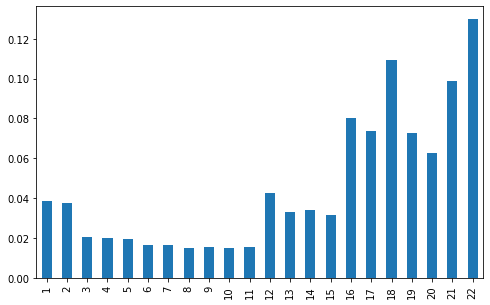

In [24]:

plt.subplots(figsize = (8,5))
(data.Reco_Policy_Cat.value_counts()/data.shape[0]).plot.bar()
plt.show()

In [25]:
# Convert to categorical data type

data.Reco_Policy_Cat = data.Reco_Policy_Cat.astype('object')
# test
data_t.Reco_Policy_Cat = data_t.Reco_Policy_Cat.astype('object')

In [26]:
pd.crosstab(index = data['Reco_Policy_Cat'],
            columns = data.Response,
            normalize = 'index')

Response,0,1
Reco_Policy_Cat,,
1,0.995933,0.004067
2,0.867501,0.132499
3,0.806421,0.193579
4,0.926108,0.073892
5,0.709037,0.290963
6,0.827262,0.172738
7,0.814149,0.185851
8,0.730670,0.269330
9,0.833967,0.166033


It can be observed that some policies have better response rate over others.

#### 1.13 Reco_Policy_Premium

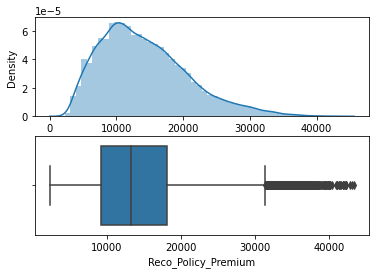

In [27]:
plt.subplot(2, 1, 1)
sns.distplot(data.Reco_Policy_Premium)
plt.subplot(2, 1, 2)
sns.boxplot(data.Reco_Policy_Premium)
plt.show()

#### 1.14 Response

In [28]:
data.Response.value_counts()

0    38673
1    12209
Name: Response, dtype: int64

## 2. Data Cleaning

In [29]:
# Replacing NaN from 'Holding_Policy_Type' with 0


data['Holding_Policy_Type'] = data['Holding_Policy_Type'].fillna(0)
# test
data_t['Holding_Policy_Type'] = data_t['Holding_Policy_Type'].fillna(0)

data.head()

,City_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,C3,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,C5,Owned,Joint,75,22,No,X2,NaN,0.0,22,30510.0,0
2,C5,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,C24,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,C8,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [30]:
data['Holding_Policy_Type'].value_counts(dropna=False)

0.0    20251
3.0    13279
1.0    8173 
2.0    5005 
4.0    4174 
Name: Holding_Policy_Type, dtype: int64

In [31]:
# Replacing NaN from 'Health Indicator' column with 'no_data'

data['Health Indicator'] = data['Health Indicator'].fillna('no_data')
# test
data_t['Health Indicator'] = data_t['Health Indicator'].fillna('no_data')

data.head()

,City_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,C3,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,C5,Owned,Joint,75,22,No,X2,NaN,0.0,22,30510.0,0
2,C5,Owned,Individual,32,32,No,no_data,1.0,1.0,19,7450.0,1
3,C24,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,C8,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [32]:
# Holding_Policy_Duration

data.Holding_Policy_Duration.value_counts(dropna = False)

NaN     20251
1.0     4499 
14+     4335 
2.0     4260 
3.0     3586 
4.0     2771 
5.0     2362 
6.0     1894 
7.0     1645 
8.0     1316 
9.0     1114 
10.0    813  
11.0    546  
12.0    513  
13.0    511  
14.0    466  
Name: Holding_Policy_Duration, dtype: int64

In [33]:
# cleaning 'Holding_Policy_Duration' column

data['Holding_Policy_Duration'] = data['Holding_Policy_Duration'].str.replace('+', '').astype('float64')
data['Holding_Policy_Duration'] = data['Holding_Policy_Duration'].fillna(0)
# test
data_t['Holding_Policy_Duration'] = data_t['Holding_Policy_Duration'].str.replace('+', '').astype('float64')
data_t['Holding_Policy_Duration'] = data_t['Holding_Policy_Duration'].fillna(0)

data.Holding_Policy_Duration.value_counts()

0.0     20251
14.0    4801 
1.0     4499 
2.0     4260 
3.0     3586 
4.0     2771 
5.0     2362 
6.0     1894 
7.0     1645 
8.0     1316 
9.0     1114 
10.0    813  
11.0    546  
12.0    513  
13.0    511  
Name: Holding_Policy_Duration, dtype: int64

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   City_Code                50882 non-null  object 
 1   Accomodation_Type        50882 non-null  object 
 2   Reco_Insurance_Type      50882 non-null  object 
 3   Upper_Age                50882 non-null  int64  
 4   Lower_Age                50882 non-null  int64  
 5   Is_Spouse                50882 non-null  object 
 6   Health Indicator         50882 non-null  object 
 7   Holding_Policy_Duration  50882 non-null  float64
 8   Holding_Policy_Type      50882 non-null  float64
 9   Reco_Policy_Cat          50882 non-null  object 
 10  Reco_Policy_Premium      50882 non-null  float64
 11  Response                 50882 non-null  int64  
dtypes: float64(3), int64(3), object(6)
memory usage: 4.7+ MB


There are not any null values in the dataset now.

## 3. Data Visualization

<AxesSubplot:>

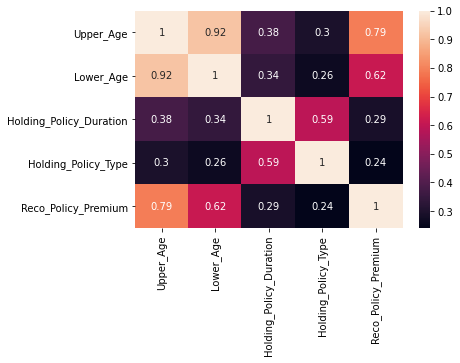

In [35]:
sns.heatmap(data.drop('Response',axis=1).corr(), annot=True)

Response policy premium has high correlation with upper age which is expected.

## 4. Data Preparation

In [36]:
# Derived column: avg_age

data['avg_age'] = (data['Upper_Age'] + data['Lower_Age'])/2
# test
data_t['avg_age'] = (data_t['Upper_Age'] + data_t['Lower_Age'])/2

In [37]:
print(data.shape)
data.head()

(50882, 13)


,City_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,avg_age
0,C3,Rented,Individual,36,36,No,X1,14.0,3.0,22,11628.0,0,36.0
1,C5,Owned,Joint,75,22,No,X2,0.0,0.0,22,30510.0,0,48.5
2,C5,Owned,Individual,32,32,No,no_data,1.0,1.0,19,7450.0,1,32.0
3,C24,Owned,Joint,52,48,No,X1,14.0,3.0,19,17780.0,0,50.0
4,C8,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0,44.0


In [38]:
# test
print(data_t.shape)
data_t.head()

(21805, 13)


,ID,City_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,avg_age
0,50883,C1,Owned,Individual,30,30,No,no_data,6.0,3.0,5,11934.0,30.0
1,50884,C4,Owned,Joint,69,68,Yes,X1,3.0,3.0,18,32204.8,68.5
2,50885,C1,Rented,Individual,28,28,No,X3,2.0,4.0,17,9240.0,28.0
3,50886,C3,Rented,Individual,23,23,No,X3,3.0,3.0,18,9086.0,23.0
4,50887,C1,Owned,Individual,75,75,No,X3,0.0,0.0,5,22534.0,75.0


In [39]:
X = data.drop('Response', axis=1)
y = data['Response']
# test
X_t = data_t.drop('ID', axis=1)

In [40]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   City_Code                50882 non-null  object 
 1   Accomodation_Type        50882 non-null  object 
 2   Reco_Insurance_Type      50882 non-null  object 
 3   Upper_Age                50882 non-null  int64  
 4   Lower_Age                50882 non-null  int64  
 5   Is_Spouse                50882 non-null  object 
 6   Health Indicator         50882 non-null  object 
 7   Holding_Policy_Duration  50882 non-null  float64
 8   Holding_Policy_Type      50882 non-null  float64
 9   Reco_Policy_Cat          50882 non-null  object 
 10  Reco_Policy_Premium      50882 non-null  float64
 11  avg_age                  50882 non-null  float64
dtypes: float64(4), int64(2), object(6)
memory usage: 4.7+ MB


In [41]:
X_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21805 entries, 0 to 21804
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   City_Code                21805 non-null  object 
 1   Accomodation_Type        21805 non-null  object 
 2   Reco_Insurance_Type      21805 non-null  object 
 3   Upper_Age                21805 non-null  int64  
 4   Lower_Age                21805 non-null  int64  
 5   Is_Spouse                21805 non-null  object 
 6   Health Indicator         21805 non-null  object 
 7   Holding_Policy_Duration  21805 non-null  float64
 8   Holding_Policy_Type      21805 non-null  float64
 9   Reco_Policy_Cat          21805 non-null  object 
 10  Reco_Policy_Premium      21805 non-null  float64
 11  avg_age                  21805 non-null  float64
dtypes: float64(4), int64(2), object(6)
memory usage: 2.0+ MB


In [42]:
# num_cols

num_cols = X.select_dtypes(include=('int64', 'float64')).columns
num_cols

Index(['Upper_Age', 'Lower_Age', 'Holding_Policy_Duration',
       'Holding_Policy_Type', 'Reco_Policy_Premium', 'avg_age'],
      dtype='object')

In [43]:
# cat_cols

cat_cols = X.select_dtypes('object').columns
cat_cols

Index(['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse',
       'Health Indicator', 'Reco_Policy_Cat'],
      dtype='object')

In [44]:
X.head()

,City_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,avg_age
0,C3,Rented,Individual,36,36,No,X1,14.0,3.0,22,11628.0,36.0
1,C5,Owned,Joint,75,22,No,X2,0.0,0.0,22,30510.0,48.5
2,C5,Owned,Individual,32,32,No,no_data,1.0,1.0,19,7450.0,32.0
3,C24,Owned,Joint,52,48,No,X1,14.0,3.0,19,17780.0,50.0
4,C8,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,44.0


In [45]:
X_t.head()

,City_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,avg_age
0,C1,Owned,Individual,30,30,No,no_data,6.0,3.0,5,11934.0,30.0
1,C4,Owned,Joint,69,68,Yes,X1,3.0,3.0,18,32204.8,68.5
2,C1,Rented,Individual,28,28,No,X3,2.0,4.0,17,9240.0,28.0
3,C3,Rented,Individual,23,23,No,X3,3.0,3.0,18,9086.0,23.0
4,C1,Owned,Individual,75,75,No,X3,0.0,0.0,5,22534.0,75.0


## 5. Train-Test split

In [46]:
# train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size = 0.8, 
                                                    test_size = 0.2, 
                                                    random_state = 100,
                                                    stratify = y)

In [47]:
#use MinMaxScaler is scale the predictors (X)
scaler = MinMaxScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])
# test
X_t[num_cols] = scaler.transform(X_t[num_cols])

In [48]:
print(X_train.shape)

X_train.head()

(40705, 12)


,City_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,avg_age
24206,C4,Rented,Individual,0.877193,0.881356,No,X4,1.000000,0.75,22,0.303430,0.878261
37495,C1,Owned,Joint,0.929825,0.610169,No,X1,0.357143,0.75,22,0.637832,0.765217
41274,C4,Rented,Individual,0.052632,0.084746,No,X1,0.000000,0.00,14,0.149012,0.060870
1584,C1,Owned,Joint,0.614035,0.610169,Yes,X4,0.142857,0.75,22,0.519810,0.608696
15951,C3,Rented,Individual,0.070175,0.101695,No,X2,0.000000,0.00,18,0.220694,0.078261


In [49]:
y_train.head()

24206    0
37495    0
41274    1
1584     0
15951    0
Name: Response, dtype: int64

In [50]:
print(X_test.shape)

X_test.head()

(10177, 12)


,City_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,avg_age
26425,C4,Owned,Individual,1.000000,1.000000,No,X1,0.214286,0.25,21,0.509369,1.000000
1463,C21,Rented,Individual,0.929825,0.932203,No,X2,0.357143,0.50,20,0.418842,0.930435
17621,C23,Rented,Individual,0.070175,0.101695,No,X3,0.000000,0.00,18,0.160602,0.078261
24375,C1,Rented,Individual,0.894737,0.898305,No,no_data,1.000000,0.25,16,0.298609,0.895652
19664,C15,Rented,Individual,0.561404,0.576271,No,X4,0.000000,0.00,1,0.388991,0.565217


In [51]:
y_test.head()

26425    0
1463     1
17621    0
24375    0
19664    0
Name: Response, dtype: int64

## 6. Model Development - Validation and Evaluation

### CATBOOST

In [52]:
# model development
# defining categorical feature columns

model_cat = CatBoostClassifier(iterations=10000, cat_features=cat_cols)

model_cat.fit(X_train, y_train)

# prediction
y_pred_train_cat = model_cat.predict_proba(X_train)
y_pred_test_cat = model_cat.predict_proba(X_test)



print('Train ROC AUC score', roc_auc_score(y_train, y_pred_train_cat[:,1]))
print('Validation ROC AUC score', roc_auc_score(y_test, y_pred_test_cat[:,1]))

Learning rate set to 0.006071
0:	learn: 0.6913301	total: 99.8ms	remaining: 16m 38s
1:	learn: 0.6895364	total: 131ms	remaining: 10m 54s
2:	learn: 0.6877682	total: 153ms	remaining: 8m 29s
3:	learn: 0.6860184	total: 192ms	remaining: 7m 58s
4:	learn: 0.6840459	total: 246ms	remaining: 8m 11s
5:	learn: 0.6818964	total: 277ms	remaining: 7m 41s
6:	learn: 0.6798399	total: 308ms	remaining: 7m 19s
7:	learn: 0.6778319	total: 363ms	remaining: 7m 33s
8:	learn: 0.6757825	total: 388ms	remaining: 7m 10s
9:	learn: 0.6739359	total: 417ms	remaining: 6m 56s
10:	learn: 0.6719229	total: 461ms	remaining: 6m 59s
11:	learn: 0.6699784	total: 502ms	remaining: 6m 57s
12:	learn: 0.6682740	total: 546ms	remaining: 6m 59s
13:	learn: 0.6663252	total: 575ms	remaining: 6m 50s
14:	learn: 0.6644976	total: 601ms	remaining: 6m 39s
15:	learn: 0.6626307	total: 625ms	remaining: 6m 30s
16:	learn: 0.6610386	total: 646ms	remaining: 6m 19s
17:	learn: 0.6593085	total: 688ms	remaining: 6m 21s
18:	learn: 0.6576314	total: 712ms	remaini

163:	learn: 0.5519688	total: 5.27s	remaining: 5m 16s
164:	learn: 0.5516468	total: 5.32s	remaining: 5m 17s
165:	learn: 0.5514240	total: 5.34s	remaining: 5m 16s
166:	learn: 0.5511551	total: 5.38s	remaining: 5m 17s
167:	learn: 0.5509116	total: 5.43s	remaining: 5m 18s
168:	learn: 0.5505876	total: 5.49s	remaining: 5m 19s
169:	learn: 0.5503430	total: 5.54s	remaining: 5m 20s
170:	learn: 0.5500310	total: 5.58s	remaining: 5m 20s
171:	learn: 0.5497076	total: 5.63s	remaining: 5m 21s
172:	learn: 0.5494915	total: 5.67s	remaining: 5m 21s
173:	learn: 0.5492356	total: 5.69s	remaining: 5m 21s
174:	learn: 0.5489812	total: 5.73s	remaining: 5m 21s
175:	learn: 0.5487731	total: 5.76s	remaining: 5m 21s
176:	learn: 0.5486025	total: 5.77s	remaining: 5m 20s
177:	learn: 0.5484091	total: 5.8s	remaining: 5m 20s
178:	learn: 0.5482080	total: 5.83s	remaining: 5m 20s
179:	learn: 0.5478927	total: 5.86s	remaining: 5m 19s
180:	learn: 0.5476884	total: 5.89s	remaining: 5m 19s
181:	learn: 0.5474752	total: 5.93s	remaining: 5

326:	learn: 0.5289551	total: 10.2s	remaining: 5m
327:	learn: 0.5288344	total: 10.2s	remaining: 5m
328:	learn: 0.5287490	total: 10.2s	remaining: 5m
329:	learn: 0.5286882	total: 10.2s	remaining: 5m
330:	learn: 0.5285658	total: 10.3s	remaining: 5m
331:	learn: 0.5284704	total: 10.3s	remaining: 4m 59s
332:	learn: 0.5284015	total: 10.3s	remaining: 4m 59s
333:	learn: 0.5283339	total: 10.4s	remaining: 4m 59s
334:	learn: 0.5282568	total: 10.4s	remaining: 4m 59s
335:	learn: 0.5281667	total: 10.4s	remaining: 4m 59s
336:	learn: 0.5281300	total: 10.4s	remaining: 4m 59s
337:	learn: 0.5280421	total: 10.5s	remaining: 4m 59s
338:	learn: 0.5279333	total: 10.5s	remaining: 4m 59s
339:	learn: 0.5278704	total: 10.5s	remaining: 4m 59s
340:	learn: 0.5277701	total: 10.6s	remaining: 4m 58s
341:	learn: 0.5277071	total: 10.6s	remaining: 4m 59s
342:	learn: 0.5276295	total: 10.6s	remaining: 4m 59s
343:	learn: 0.5275551	total: 10.7s	remaining: 4m 58s
344:	learn: 0.5274788	total: 10.7s	remaining: 4m 58s
345:	learn: 0

487:	learn: 0.5211688	total: 15s	remaining: 4m 53s
488:	learn: 0.5211461	total: 15.1s	remaining: 4m 53s
489:	learn: 0.5211437	total: 15.1s	remaining: 4m 52s
490:	learn: 0.5211198	total: 15.1s	remaining: 4m 52s
491:	learn: 0.5210951	total: 15.1s	remaining: 4m 52s
492:	learn: 0.5210928	total: 15.2s	remaining: 4m 52s
493:	learn: 0.5210602	total: 15.2s	remaining: 4m 52s
494:	learn: 0.5210363	total: 15.2s	remaining: 4m 52s
495:	learn: 0.5210216	total: 15.3s	remaining: 4m 52s
496:	learn: 0.5210033	total: 15.3s	remaining: 4m 52s
497:	learn: 0.5209707	total: 15.3s	remaining: 4m 52s
498:	learn: 0.5209486	total: 15.4s	remaining: 4m 52s
499:	learn: 0.5209192	total: 15.4s	remaining: 4m 52s
500:	learn: 0.5208964	total: 15.4s	remaining: 4m 52s
501:	learn: 0.5208376	total: 15.4s	remaining: 4m 52s
502:	learn: 0.5207967	total: 15.5s	remaining: 4m 52s
503:	learn: 0.5207765	total: 15.5s	remaining: 4m 52s
504:	learn: 0.5207746	total: 15.5s	remaining: 4m 51s
505:	learn: 0.5207471	total: 15.6s	remaining: 4m

649:	learn: 0.5178325	total: 19.9s	remaining: 4m 46s
650:	learn: 0.5178182	total: 20s	remaining: 4m 46s
651:	learn: 0.5178061	total: 20s	remaining: 4m 46s
652:	learn: 0.5177901	total: 20s	remaining: 4m 46s
653:	learn: 0.5177641	total: 20.1s	remaining: 4m 46s
654:	learn: 0.5177481	total: 20.1s	remaining: 4m 46s
655:	learn: 0.5177370	total: 20.1s	remaining: 4m 46s
656:	learn: 0.5177176	total: 20.2s	remaining: 4m 46s
657:	learn: 0.5177062	total: 20.2s	remaining: 4m 46s
658:	learn: 0.5176783	total: 20.2s	remaining: 4m 46s
659:	learn: 0.5176711	total: 20.3s	remaining: 4m 46s
660:	learn: 0.5176595	total: 20.3s	remaining: 4m 46s
661:	learn: 0.5176510	total: 20.3s	remaining: 4m 46s
662:	learn: 0.5176325	total: 20.4s	remaining: 4m 46s
663:	learn: 0.5176202	total: 20.4s	remaining: 4m 46s
664:	learn: 0.5176031	total: 20.4s	remaining: 4m 46s
665:	learn: 0.5175847	total: 20.5s	remaining: 4m 46s
666:	learn: 0.5175461	total: 20.5s	remaining: 4m 46s
667:	learn: 0.5175076	total: 20.5s	remaining: 4m 46s

810:	learn: 0.5152838	total: 25.8s	remaining: 4m 51s
811:	learn: 0.5152734	total: 25.8s	remaining: 4m 51s
812:	learn: 0.5152637	total: 25.8s	remaining: 4m 51s
813:	learn: 0.5152564	total: 25.8s	remaining: 4m 51s
814:	learn: 0.5152537	total: 25.9s	remaining: 4m 51s
815:	learn: 0.5152405	total: 25.9s	remaining: 4m 51s
816:	learn: 0.5152272	total: 25.9s	remaining: 4m 51s
817:	learn: 0.5152027	total: 26s	remaining: 4m 51s
818:	learn: 0.5151799	total: 26s	remaining: 4m 51s
819:	learn: 0.5151701	total: 26s	remaining: 4m 51s
820:	learn: 0.5151622	total: 26.1s	remaining: 4m 51s
821:	learn: 0.5151486	total: 26.1s	remaining: 4m 51s
822:	learn: 0.5151465	total: 26.1s	remaining: 4m 51s
823:	learn: 0.5151400	total: 26.2s	remaining: 4m 51s
824:	learn: 0.5151345	total: 26.2s	remaining: 4m 51s
825:	learn: 0.5150741	total: 26.2s	remaining: 4m 51s
826:	learn: 0.5150684	total: 26.3s	remaining: 4m 51s
827:	learn: 0.5150524	total: 26.3s	remaining: 4m 51s
828:	learn: 0.5150480	total: 26.3s	remaining: 4m 51s

968:	learn: 0.5135440	total: 31.1s	remaining: 4m 49s
969:	learn: 0.5135390	total: 31.1s	remaining: 4m 49s
970:	learn: 0.5135325	total: 31.2s	remaining: 4m 49s
971:	learn: 0.5135198	total: 31.2s	remaining: 4m 49s
972:	learn: 0.5135059	total: 31.2s	remaining: 4m 49s
973:	learn: 0.5135010	total: 31.2s	remaining: 4m 49s
974:	learn: 0.5134955	total: 31.3s	remaining: 4m 49s
975:	learn: 0.5134893	total: 31.3s	remaining: 4m 49s
976:	learn: 0.5134804	total: 31.3s	remaining: 4m 49s
977:	learn: 0.5134719	total: 31.4s	remaining: 4m 49s
978:	learn: 0.5134493	total: 31.4s	remaining: 4m 49s
979:	learn: 0.5134446	total: 31.4s	remaining: 4m 49s
980:	learn: 0.5134380	total: 31.5s	remaining: 4m 49s
981:	learn: 0.5133985	total: 31.5s	remaining: 4m 49s
982:	learn: 0.5133888	total: 31.5s	remaining: 4m 49s
983:	learn: 0.5133861	total: 31.6s	remaining: 4m 49s
984:	learn: 0.5133767	total: 31.6s	remaining: 4m 49s
985:	learn: 0.5133662	total: 31.6s	remaining: 4m 49s
986:	learn: 0.5133587	total: 31.7s	remaining: 

1127:	learn: 0.5119357	total: 36.8s	remaining: 4m 49s
1128:	learn: 0.5119268	total: 36.8s	remaining: 4m 49s
1129:	learn: 0.5119148	total: 36.8s	remaining: 4m 48s
1130:	learn: 0.5119078	total: 36.8s	remaining: 4m 48s
1131:	learn: 0.5119019	total: 36.9s	remaining: 4m 48s
1132:	learn: 0.5118736	total: 36.9s	remaining: 4m 48s
1133:	learn: 0.5118644	total: 36.9s	remaining: 4m 48s
1134:	learn: 0.5118585	total: 37s	remaining: 4m 48s
1135:	learn: 0.5118506	total: 37s	remaining: 4m 48s
1136:	learn: 0.5118478	total: 37s	remaining: 4m 48s
1137:	learn: 0.5118371	total: 37.1s	remaining: 4m 48s
1138:	learn: 0.5118335	total: 37.1s	remaining: 4m 48s
1139:	learn: 0.5118316	total: 37.1s	remaining: 4m 48s
1140:	learn: 0.5118055	total: 37.1s	remaining: 4m 48s
1141:	learn: 0.5117999	total: 37.2s	remaining: 4m 48s
1142:	learn: 0.5117878	total: 37.2s	remaining: 4m 48s
1143:	learn: 0.5117813	total: 37.2s	remaining: 4m 48s
1144:	learn: 0.5117771	total: 37.3s	remaining: 4m 48s
1145:	learn: 0.5117699	total: 37.3

1285:	learn: 0.5105352	total: 42s	remaining: 4m 44s
1286:	learn: 0.5105322	total: 42s	remaining: 4m 44s
1287:	learn: 0.5105296	total: 42.1s	remaining: 4m 44s
1288:	learn: 0.5105253	total: 42.1s	remaining: 4m 44s
1289:	learn: 0.5105150	total: 42.1s	remaining: 4m 44s
1290:	learn: 0.5105085	total: 42.2s	remaining: 4m 44s
1291:	learn: 0.5104976	total: 42.2s	remaining: 4m 44s
1292:	learn: 0.5104924	total: 42.2s	remaining: 4m 44s
1293:	learn: 0.5104869	total: 42.3s	remaining: 4m 44s
1294:	learn: 0.5104796	total: 42.3s	remaining: 4m 44s
1295:	learn: 0.5104760	total: 42.3s	remaining: 4m 44s
1296:	learn: 0.5104702	total: 42.4s	remaining: 4m 44s
1297:	learn: 0.5104678	total: 42.4s	remaining: 4m 44s
1298:	learn: 0.5104610	total: 42.4s	remaining: 4m 44s
1299:	learn: 0.5104531	total: 42.5s	remaining: 4m 44s
1300:	learn: 0.5104398	total: 42.5s	remaining: 4m 44s
1301:	learn: 0.5104284	total: 42.5s	remaining: 4m 44s
1302:	learn: 0.5104228	total: 42.6s	remaining: 4m 44s
1303:	learn: 0.5104208	total: 42

1443:	learn: 0.5093734	total: 47.2s	remaining: 4m 39s
1444:	learn: 0.5093692	total: 47.2s	remaining: 4m 39s
1445:	learn: 0.5093588	total: 47.2s	remaining: 4m 39s
1446:	learn: 0.5093388	total: 47.3s	remaining: 4m 39s
1447:	learn: 0.5093314	total: 47.3s	remaining: 4m 39s
1448:	learn: 0.5093276	total: 47.3s	remaining: 4m 39s
1449:	learn: 0.5093275	total: 47.3s	remaining: 4m 39s
1450:	learn: 0.5093233	total: 47.4s	remaining: 4m 39s
1451:	learn: 0.5093118	total: 47.4s	remaining: 4m 39s
1452:	learn: 0.5093004	total: 47.4s	remaining: 4m 39s
1453:	learn: 0.5092692	total: 47.5s	remaining: 4m 39s
1454:	learn: 0.5092626	total: 47.5s	remaining: 4m 38s
1455:	learn: 0.5092567	total: 47.5s	remaining: 4m 38s
1456:	learn: 0.5092495	total: 47.6s	remaining: 4m 38s
1457:	learn: 0.5092457	total: 47.6s	remaining: 4m 38s
1458:	learn: 0.5092330	total: 47.6s	remaining: 4m 38s
1459:	learn: 0.5092238	total: 47.7s	remaining: 4m 38s
1460:	learn: 0.5092172	total: 47.7s	remaining: 4m 38s
1461:	learn: 0.5092114	total

1597:	learn: 0.5082036	total: 52.2s	remaining: 4m 34s
1598:	learn: 0.5081962	total: 52.2s	remaining: 4m 34s
1599:	learn: 0.5081886	total: 52.3s	remaining: 4m 34s
1600:	learn: 0.5081799	total: 52.3s	remaining: 4m 34s
1601:	learn: 0.5081719	total: 52.3s	remaining: 4m 34s
1602:	learn: 0.5081613	total: 52.4s	remaining: 4m 34s
1603:	learn: 0.5081588	total: 52.4s	remaining: 4m 34s
1604:	learn: 0.5081539	total: 52.4s	remaining: 4m 34s
1605:	learn: 0.5081512	total: 52.5s	remaining: 4m 34s
1606:	learn: 0.5081433	total: 52.5s	remaining: 4m 34s
1607:	learn: 0.5081211	total: 52.5s	remaining: 4m 34s
1608:	learn: 0.5081146	total: 52.6s	remaining: 4m 34s
1609:	learn: 0.5081085	total: 52.6s	remaining: 4m 34s
1610:	learn: 0.5080917	total: 52.6s	remaining: 4m 34s
1611:	learn: 0.5080889	total: 52.7s	remaining: 4m 34s
1612:	learn: 0.5080857	total: 52.7s	remaining: 4m 34s
1613:	learn: 0.5080799	total: 52.7s	remaining: 4m 34s
1614:	learn: 0.5080720	total: 52.8s	remaining: 4m 34s
1615:	learn: 0.5080650	total

1753:	learn: 0.5069326	total: 58s	remaining: 4m 32s
1754:	learn: 0.5069198	total: 58.1s	remaining: 4m 32s
1755:	learn: 0.5069160	total: 58.1s	remaining: 4m 32s
1756:	learn: 0.5069160	total: 58.1s	remaining: 4m 32s
1757:	learn: 0.5069048	total: 58.2s	remaining: 4m 32s
1758:	learn: 0.5069019	total: 58.2s	remaining: 4m 32s
1759:	learn: 0.5068885	total: 58.2s	remaining: 4m 32s
1760:	learn: 0.5068813	total: 58.3s	remaining: 4m 32s
1761:	learn: 0.5068676	total: 58.3s	remaining: 4m 32s
1762:	learn: 0.5068606	total: 58.3s	remaining: 4m 32s
1763:	learn: 0.5068561	total: 58.4s	remaining: 4m 32s
1764:	learn: 0.5068523	total: 58.4s	remaining: 4m 32s
1765:	learn: 0.5068429	total: 58.4s	remaining: 4m 32s
1766:	learn: 0.5068397	total: 58.5s	remaining: 4m 32s
1767:	learn: 0.5068316	total: 58.5s	remaining: 4m 32s
1768:	learn: 0.5068239	total: 58.5s	remaining: 4m 32s
1769:	learn: 0.5068203	total: 58.6s	remaining: 4m 32s
1770:	learn: 0.5068098	total: 58.6s	remaining: 4m 32s
1771:	learn: 0.5068016	total: 

1908:	learn: 0.5057987	total: 1m 3s	remaining: 4m 29s
1909:	learn: 0.5057929	total: 1m 3s	remaining: 4m 29s
1910:	learn: 0.5057902	total: 1m 3s	remaining: 4m 29s
1911:	learn: 0.5057783	total: 1m 3s	remaining: 4m 29s
1912:	learn: 0.5057711	total: 1m 3s	remaining: 4m 29s
1913:	learn: 0.5057640	total: 1m 3s	remaining: 4m 28s
1914:	learn: 0.5057595	total: 1m 3s	remaining: 4m 28s
1915:	learn: 0.5057549	total: 1m 3s	remaining: 4m 28s
1916:	learn: 0.5057549	total: 1m 3s	remaining: 4m 28s
1917:	learn: 0.5057417	total: 1m 3s	remaining: 4m 28s
1918:	learn: 0.5057277	total: 1m 3s	remaining: 4m 28s
1919:	learn: 0.5057153	total: 1m 3s	remaining: 4m 28s
1920:	learn: 0.5057081	total: 1m 3s	remaining: 4m 28s
1921:	learn: 0.5056824	total: 1m 3s	remaining: 4m 28s
1922:	learn: 0.5056756	total: 1m 3s	remaining: 4m 28s
1923:	learn: 0.5056676	total: 1m 4s	remaining: 4m 28s
1924:	learn: 0.5056671	total: 1m 4s	remaining: 4m 28s
1925:	learn: 0.5056607	total: 1m 4s	remaining: 4m 28s
1926:	learn: 0.5056531	total

2060:	learn: 0.5046997	total: 1m 8s	remaining: 4m 25s
2061:	learn: 0.5046965	total: 1m 9s	remaining: 4m 25s
2062:	learn: 0.5046952	total: 1m 9s	remaining: 4m 26s
2063:	learn: 0.5046947	total: 1m 9s	remaining: 4m 26s
2064:	learn: 0.5046873	total: 1m 9s	remaining: 4m 25s
2065:	learn: 0.5046811	total: 1m 9s	remaining: 4m 26s
2066:	learn: 0.5046771	total: 1m 9s	remaining: 4m 26s
2067:	learn: 0.5046687	total: 1m 9s	remaining: 4m 26s
2068:	learn: 0.5046624	total: 1m 9s	remaining: 4m 26s
2069:	learn: 0.5046593	total: 1m 9s	remaining: 4m 26s
2070:	learn: 0.5046491	total: 1m 9s	remaining: 4m 26s
2071:	learn: 0.5046478	total: 1m 9s	remaining: 4m 26s
2072:	learn: 0.5046434	total: 1m 9s	remaining: 4m 26s
2073:	learn: 0.5046365	total: 1m 9s	remaining: 4m 26s
2074:	learn: 0.5046333	total: 1m 9s	remaining: 4m 26s
2075:	learn: 0.5046261	total: 1m 9s	remaining: 4m 26s
2076:	learn: 0.5046146	total: 1m 9s	remaining: 4m 26s
2077:	learn: 0.5046001	total: 1m 10s	remaining: 4m 27s
2078:	learn: 0.5045924	tota

2210:	learn: 0.5035930	total: 1m 19s	remaining: 4m 41s
2211:	learn: 0.5035851	total: 1m 19s	remaining: 4m 41s
2212:	learn: 0.5035750	total: 1m 19s	remaining: 4m 41s
2213:	learn: 0.5035657	total: 1m 19s	remaining: 4m 41s
2214:	learn: 0.5035607	total: 1m 20s	remaining: 4m 41s
2215:	learn: 0.5035514	total: 1m 20s	remaining: 4m 41s
2216:	learn: 0.5035464	total: 1m 20s	remaining: 4m 41s
2217:	learn: 0.5035351	total: 1m 20s	remaining: 4m 41s
2218:	learn: 0.5035323	total: 1m 20s	remaining: 4m 41s
2219:	learn: 0.5035214	total: 1m 20s	remaining: 4m 41s
2220:	learn: 0.5035157	total: 1m 20s	remaining: 4m 41s
2221:	learn: 0.5035110	total: 1m 20s	remaining: 4m 40s
2222:	learn: 0.5035047	total: 1m 20s	remaining: 4m 41s
2223:	learn: 0.5034937	total: 1m 20s	remaining: 4m 40s
2224:	learn: 0.5034811	total: 1m 20s	remaining: 4m 40s
2225:	learn: 0.5034684	total: 1m 20s	remaining: 4m 40s
2226:	learn: 0.5034617	total: 1m 20s	remaining: 4m 40s
2227:	learn: 0.5034520	total: 1m 20s	remaining: 4m 40s
2228:	lear

2362:	learn: 0.5024462	total: 1m 26s	remaining: 4m 38s
2363:	learn: 0.5024409	total: 1m 26s	remaining: 4m 38s
2364:	learn: 0.5024342	total: 1m 26s	remaining: 4m 38s
2365:	learn: 0.5024278	total: 1m 26s	remaining: 4m 38s
2366:	learn: 0.5024212	total: 1m 26s	remaining: 4m 38s
2367:	learn: 0.5024194	total: 1m 26s	remaining: 4m 38s
2368:	learn: 0.5024164	total: 1m 26s	remaining: 4m 38s
2369:	learn: 0.5024087	total: 1m 26s	remaining: 4m 38s
2370:	learn: 0.5024031	total: 1m 26s	remaining: 4m 38s
2371:	learn: 0.5023915	total: 1m 26s	remaining: 4m 38s
2372:	learn: 0.5023868	total: 1m 26s	remaining: 4m 38s
2373:	learn: 0.5023815	total: 1m 26s	remaining: 4m 38s
2374:	learn: 0.5023723	total: 1m 26s	remaining: 4m 38s
2375:	learn: 0.5023710	total: 1m 26s	remaining: 4m 38s
2376:	learn: 0.5023590	total: 1m 26s	remaining: 4m 38s
2377:	learn: 0.5023546	total: 1m 26s	remaining: 4m 38s
2378:	learn: 0.5023446	total: 1m 26s	remaining: 4m 38s
2379:	learn: 0.5023329	total: 1m 26s	remaining: 4m 38s
2380:	lear

2511:	learn: 0.5013914	total: 1m 32s	remaining: 4m 34s
2512:	learn: 0.5013870	total: 1m 32s	remaining: 4m 34s
2513:	learn: 0.5013831	total: 1m 32s	remaining: 4m 34s
2514:	learn: 0.5013787	total: 1m 32s	remaining: 4m 34s
2515:	learn: 0.5013739	total: 1m 32s	remaining: 4m 34s
2516:	learn: 0.5013674	total: 1m 32s	remaining: 4m 34s
2517:	learn: 0.5013665	total: 1m 32s	remaining: 4m 34s
2518:	learn: 0.5013630	total: 1m 32s	remaining: 4m 34s
2519:	learn: 0.5013615	total: 1m 32s	remaining: 4m 34s
2520:	learn: 0.5013601	total: 1m 32s	remaining: 4m 34s
2521:	learn: 0.5013559	total: 1m 32s	remaining: 4m 34s
2522:	learn: 0.5013507	total: 1m 32s	remaining: 4m 34s
2523:	learn: 0.5013392	total: 1m 32s	remaining: 4m 34s
2524:	learn: 0.5013321	total: 1m 32s	remaining: 4m 34s
2525:	learn: 0.5013272	total: 1m 32s	remaining: 4m 34s
2526:	learn: 0.5013204	total: 1m 32s	remaining: 4m 33s
2527:	learn: 0.5013164	total: 1m 32s	remaining: 4m 33s
2528:	learn: 0.5013063	total: 1m 32s	remaining: 4m 33s
2529:	lear

2664:	learn: 0.5004154	total: 1m 38s	remaining: 4m 29s
2665:	learn: 0.5004086	total: 1m 38s	remaining: 4m 29s
2666:	learn: 0.5004039	total: 1m 38s	remaining: 4m 29s
2667:	learn: 0.5004008	total: 1m 38s	remaining: 4m 29s
2668:	learn: 0.5003981	total: 1m 38s	remaining: 4m 29s
2669:	learn: 0.5003829	total: 1m 38s	remaining: 4m 29s
2670:	learn: 0.5003731	total: 1m 38s	remaining: 4m 29s
2671:	learn: 0.5003660	total: 1m 38s	remaining: 4m 29s
2672:	learn: 0.5003616	total: 1m 38s	remaining: 4m 29s
2673:	learn: 0.5003555	total: 1m 38s	remaining: 4m 29s
2674:	learn: 0.5003455	total: 1m 38s	remaining: 4m 29s
2675:	learn: 0.5003372	total: 1m 38s	remaining: 4m 29s
2676:	learn: 0.5003360	total: 1m 38s	remaining: 4m 29s
2677:	learn: 0.5003230	total: 1m 38s	remaining: 4m 29s
2678:	learn: 0.5003202	total: 1m 38s	remaining: 4m 29s
2679:	learn: 0.5003078	total: 1m 38s	remaining: 4m 29s
2680:	learn: 0.5003035	total: 1m 38s	remaining: 4m 29s
2681:	learn: 0.5002952	total: 1m 38s	remaining: 4m 29s
2682:	lear

2817:	learn: 0.4994589	total: 1m 43s	remaining: 4m 24s
2818:	learn: 0.4994507	total: 1m 43s	remaining: 4m 24s
2819:	learn: 0.4994434	total: 1m 43s	remaining: 4m 24s
2820:	learn: 0.4994370	total: 1m 44s	remaining: 4m 24s
2821:	learn: 0.4994311	total: 1m 44s	remaining: 4m 24s
2822:	learn: 0.4994300	total: 1m 44s	remaining: 4m 24s
2823:	learn: 0.4994245	total: 1m 44s	remaining: 4m 24s
2824:	learn: 0.4994195	total: 1m 44s	remaining: 4m 24s
2825:	learn: 0.4994174	total: 1m 44s	remaining: 4m 24s
2826:	learn: 0.4994126	total: 1m 44s	remaining: 4m 24s
2827:	learn: 0.4994094	total: 1m 44s	remaining: 4m 24s
2828:	learn: 0.4994042	total: 1m 44s	remaining: 4m 24s
2829:	learn: 0.4993992	total: 1m 44s	remaining: 4m 24s
2830:	learn: 0.4993918	total: 1m 44s	remaining: 4m 24s
2831:	learn: 0.4993814	total: 1m 44s	remaining: 4m 24s
2832:	learn: 0.4993750	total: 1m 44s	remaining: 4m 24s
2833:	learn: 0.4993714	total: 1m 44s	remaining: 4m 24s
2834:	learn: 0.4993691	total: 1m 44s	remaining: 4m 24s
2835:	lear

2970:	learn: 0.4984836	total: 1m 50s	remaining: 4m 20s
2971:	learn: 0.4984807	total: 1m 50s	remaining: 4m 20s
2972:	learn: 0.4984762	total: 1m 50s	remaining: 4m 20s
2973:	learn: 0.4984566	total: 1m 50s	remaining: 4m 20s
2974:	learn: 0.4984461	total: 1m 50s	remaining: 4m 20s
2975:	learn: 0.4984392	total: 1m 50s	remaining: 4m 20s
2976:	learn: 0.4984307	total: 1m 50s	remaining: 4m 20s
2977:	learn: 0.4984236	total: 1m 50s	remaining: 4m 20s
2978:	learn: 0.4984190	total: 1m 50s	remaining: 4m 20s
2979:	learn: 0.4984072	total: 1m 50s	remaining: 4m 20s
2980:	learn: 0.4984035	total: 1m 50s	remaining: 4m 20s
2981:	learn: 0.4983968	total: 1m 50s	remaining: 4m 20s
2982:	learn: 0.4983892	total: 1m 50s	remaining: 4m 20s
2983:	learn: 0.4983805	total: 1m 50s	remaining: 4m 20s
2984:	learn: 0.4983758	total: 1m 50s	remaining: 4m 20s
2985:	learn: 0.4983699	total: 1m 50s	remaining: 4m 20s
2986:	learn: 0.4983680	total: 1m 50s	remaining: 4m 20s
2987:	learn: 0.4983663	total: 1m 50s	remaining: 4m 20s
2988:	lear

3119:	learn: 0.4975945	total: 1m 56s	remaining: 4m 16s
3120:	learn: 0.4975880	total: 1m 56s	remaining: 4m 16s
3121:	learn: 0.4975798	total: 1m 56s	remaining: 4m 16s
3122:	learn: 0.4975778	total: 1m 56s	remaining: 4m 16s
3123:	learn: 0.4975763	total: 1m 56s	remaining: 4m 16s
3124:	learn: 0.4975727	total: 1m 56s	remaining: 4m 16s
3125:	learn: 0.4975670	total: 1m 56s	remaining: 4m 16s
3126:	learn: 0.4975583	total: 1m 56s	remaining: 4m 16s
3127:	learn: 0.4975546	total: 1m 56s	remaining: 4m 16s
3128:	learn: 0.4975471	total: 1m 56s	remaining: 4m 16s
3129:	learn: 0.4975397	total: 1m 56s	remaining: 4m 16s
3130:	learn: 0.4975348	total: 1m 56s	remaining: 4m 16s
3131:	learn: 0.4975331	total: 1m 56s	remaining: 4m 16s
3132:	learn: 0.4975119	total: 1m 56s	remaining: 4m 16s
3133:	learn: 0.4975052	total: 1m 56s	remaining: 4m 16s
3134:	learn: 0.4975031	total: 1m 56s	remaining: 4m 16s
3135:	learn: 0.4974951	total: 1m 57s	remaining: 4m 16s
3136:	learn: 0.4974916	total: 1m 57s	remaining: 4m 16s
3137:	lear

3276:	learn: 0.4966729	total: 2m 2s	remaining: 4m 11s
3277:	learn: 0.4966695	total: 2m 2s	remaining: 4m 11s
3278:	learn: 0.4966674	total: 2m 2s	remaining: 4m 11s
3279:	learn: 0.4966627	total: 2m 2s	remaining: 4m 11s
3280:	learn: 0.4966508	total: 2m 2s	remaining: 4m 11s
3281:	learn: 0.4966428	total: 2m 2s	remaining: 4m 11s
3282:	learn: 0.4966397	total: 2m 2s	remaining: 4m 11s
3283:	learn: 0.4966353	total: 2m 2s	remaining: 4m 11s
3284:	learn: 0.4966340	total: 2m 2s	remaining: 4m 11s
3285:	learn: 0.4966317	total: 2m 2s	remaining: 4m 11s
3286:	learn: 0.4966240	total: 2m 2s	remaining: 4m 11s
3287:	learn: 0.4966188	total: 2m 2s	remaining: 4m 11s
3288:	learn: 0.4966163	total: 2m 3s	remaining: 4m 10s
3289:	learn: 0.4966109	total: 2m 3s	remaining: 4m 10s
3290:	learn: 0.4966089	total: 2m 3s	remaining: 4m 10s
3291:	learn: 0.4966067	total: 2m 3s	remaining: 4m 10s
3292:	learn: 0.4966035	total: 2m 3s	remaining: 4m 10s
3293:	learn: 0.4965960	total: 2m 3s	remaining: 4m 10s
3294:	learn: 0.4965939	total

3433:	learn: 0.4957708	total: 2m 8s	remaining: 4m 6s
3434:	learn: 0.4957630	total: 2m 8s	remaining: 4m 6s
3435:	learn: 0.4957571	total: 2m 8s	remaining: 4m 6s
3436:	learn: 0.4957498	total: 2m 8s	remaining: 4m 6s
3437:	learn: 0.4957411	total: 2m 8s	remaining: 4m 6s
3438:	learn: 0.4957364	total: 2m 9s	remaining: 4m 6s
3439:	learn: 0.4957315	total: 2m 9s	remaining: 4m 6s
3440:	learn: 0.4957277	total: 2m 9s	remaining: 4m 6s
3441:	learn: 0.4957170	total: 2m 9s	remaining: 4m 6s
3442:	learn: 0.4957136	total: 2m 9s	remaining: 4m 5s
3443:	learn: 0.4957081	total: 2m 9s	remaining: 4m 5s
3444:	learn: 0.4957021	total: 2m 9s	remaining: 4m 5s
3445:	learn: 0.4956967	total: 2m 9s	remaining: 4m 5s
3446:	learn: 0.4956918	total: 2m 9s	remaining: 4m 5s
3447:	learn: 0.4956895	total: 2m 9s	remaining: 4m 5s
3448:	learn: 0.4956854	total: 2m 9s	remaining: 4m 5s
3449:	learn: 0.4956802	total: 2m 9s	remaining: 4m 5s
3450:	learn: 0.4956777	total: 2m 9s	remaining: 4m 5s
3451:	learn: 0.4956717	total: 2m 9s	remaining:

3588:	learn: 0.4948715	total: 2m 14s	remaining: 4m
3589:	learn: 0.4948654	total: 2m 14s	remaining: 4m
3590:	learn: 0.4948562	total: 2m 14s	remaining: 4m
3591:	learn: 0.4948552	total: 2m 15s	remaining: 4m
3592:	learn: 0.4948514	total: 2m 15s	remaining: 4m
3593:	learn: 0.4948450	total: 2m 15s	remaining: 4m
3594:	learn: 0.4948387	total: 2m 15s	remaining: 4m
3595:	learn: 0.4948343	total: 2m 15s	remaining: 4m
3596:	learn: 0.4948325	total: 2m 15s	remaining: 4m
3597:	learn: 0.4948306	total: 2m 15s	remaining: 4m
3598:	learn: 0.4948260	total: 2m 15s	remaining: 4m
3599:	learn: 0.4948223	total: 2m 15s	remaining: 4m
3600:	learn: 0.4948204	total: 2m 15s	remaining: 4m
3601:	learn: 0.4948165	total: 2m 15s	remaining: 4m
3602:	learn: 0.4948128	total: 2m 15s	remaining: 4m
3603:	learn: 0.4948110	total: 2m 15s	remaining: 4m
3604:	learn: 0.4948058	total: 2m 15s	remaining: 4m
3605:	learn: 0.4947995	total: 2m 15s	remaining: 4m
3606:	learn: 0.4947976	total: 2m 15s	remaining: 4m
3607:	learn: 0.4947914	total: 2

3744:	learn: 0.4940910	total: 2m 21s	remaining: 3m 56s
3745:	learn: 0.4940879	total: 2m 21s	remaining: 3m 56s
3746:	learn: 0.4940823	total: 2m 21s	remaining: 3m 56s
3747:	learn: 0.4940739	total: 2m 21s	remaining: 3m 56s
3748:	learn: 0.4940701	total: 2m 21s	remaining: 3m 56s
3749:	learn: 0.4940653	total: 2m 21s	remaining: 3m 56s
3750:	learn: 0.4940638	total: 2m 21s	remaining: 3m 56s
3751:	learn: 0.4940598	total: 2m 21s	remaining: 3m 56s
3752:	learn: 0.4940499	total: 2m 21s	remaining: 3m 56s
3753:	learn: 0.4940483	total: 2m 21s	remaining: 3m 55s
3754:	learn: 0.4940433	total: 2m 21s	remaining: 3m 55s
3755:	learn: 0.4940349	total: 2m 21s	remaining: 3m 56s
3756:	learn: 0.4940303	total: 2m 22s	remaining: 3m 55s
3757:	learn: 0.4940227	total: 2m 22s	remaining: 3m 55s
3758:	learn: 0.4940185	total: 2m 22s	remaining: 3m 55s
3759:	learn: 0.4940133	total: 2m 22s	remaining: 3m 55s
3760:	learn: 0.4940074	total: 2m 22s	remaining: 3m 55s
3761:	learn: 0.4940039	total: 2m 22s	remaining: 3m 55s
3762:	lear

3894:	learn: 0.4933149	total: 2m 27s	remaining: 3m 51s
3895:	learn: 0.4933102	total: 2m 27s	remaining: 3m 51s
3896:	learn: 0.4933061	total: 2m 27s	remaining: 3m 51s
3897:	learn: 0.4933030	total: 2m 27s	remaining: 3m 51s
3898:	learn: 0.4932972	total: 2m 28s	remaining: 3m 51s
3899:	learn: 0.4932914	total: 2m 28s	remaining: 3m 51s
3900:	learn: 0.4932895	total: 2m 28s	remaining: 3m 51s
3901:	learn: 0.4932815	total: 2m 28s	remaining: 3m 51s
3902:	learn: 0.4932797	total: 2m 28s	remaining: 3m 51s
3903:	learn: 0.4932744	total: 2m 28s	remaining: 3m 51s
3904:	learn: 0.4932687	total: 2m 28s	remaining: 3m 51s
3905:	learn: 0.4932613	total: 2m 28s	remaining: 3m 51s
3906:	learn: 0.4932581	total: 2m 28s	remaining: 3m 51s
3907:	learn: 0.4932500	total: 2m 28s	remaining: 3m 51s
3908:	learn: 0.4932454	total: 2m 28s	remaining: 3m 51s
3909:	learn: 0.4932421	total: 2m 28s	remaining: 3m 51s
3910:	learn: 0.4932319	total: 2m 28s	remaining: 3m 51s
3911:	learn: 0.4932245	total: 2m 28s	remaining: 3m 51s
3912:	lear

4045:	learn: 0.4925045	total: 2m 33s	remaining: 3m 46s
4046:	learn: 0.4924988	total: 2m 33s	remaining: 3m 46s
4047:	learn: 0.4924955	total: 2m 33s	remaining: 3m 46s
4048:	learn: 0.4924950	total: 2m 33s	remaining: 3m 46s
4049:	learn: 0.4924922	total: 2m 33s	remaining: 3m 46s
4050:	learn: 0.4924745	total: 2m 33s	remaining: 3m 46s
4051:	learn: 0.4924737	total: 2m 33s	remaining: 3m 45s
4052:	learn: 0.4924699	total: 2m 34s	remaining: 3m 45s
4053:	learn: 0.4924620	total: 2m 34s	remaining: 3m 45s
4054:	learn: 0.4924577	total: 2m 34s	remaining: 3m 45s
4055:	learn: 0.4924532	total: 2m 34s	remaining: 3m 45s
4056:	learn: 0.4924497	total: 2m 34s	remaining: 3m 45s
4057:	learn: 0.4924454	total: 2m 34s	remaining: 3m 45s
4058:	learn: 0.4924376	total: 2m 34s	remaining: 3m 45s
4059:	learn: 0.4924356	total: 2m 34s	remaining: 3m 45s
4060:	learn: 0.4924302	total: 2m 34s	remaining: 3m 45s
4061:	learn: 0.4924280	total: 2m 34s	remaining: 3m 45s
4062:	learn: 0.4924195	total: 2m 34s	remaining: 3m 45s
4063:	lear

4198:	learn: 0.4917179	total: 2m 39s	remaining: 3m 40s
4199:	learn: 0.4917117	total: 2m 39s	remaining: 3m 40s
4200:	learn: 0.4916983	total: 2m 39s	remaining: 3m 40s
4201:	learn: 0.4916921	total: 2m 39s	remaining: 3m 40s
4202:	learn: 0.4916899	total: 2m 39s	remaining: 3m 40s
4203:	learn: 0.4916814	total: 2m 39s	remaining: 3m 40s
4204:	learn: 0.4916761	total: 2m 39s	remaining: 3m 40s
4205:	learn: 0.4916706	total: 2m 39s	remaining: 3m 40s
4206:	learn: 0.4916652	total: 2m 39s	remaining: 3m 40s
4207:	learn: 0.4916621	total: 2m 39s	remaining: 3m 39s
4208:	learn: 0.4916582	total: 2m 39s	remaining: 3m 39s
4209:	learn: 0.4916541	total: 2m 39s	remaining: 3m 39s
4210:	learn: 0.4916501	total: 2m 39s	remaining: 3m 39s
4211:	learn: 0.4916448	total: 2m 39s	remaining: 3m 39s
4212:	learn: 0.4916415	total: 2m 40s	remaining: 3m 39s
4213:	learn: 0.4916374	total: 2m 40s	remaining: 3m 39s
4214:	learn: 0.4916306	total: 2m 40s	remaining: 3m 39s
4215:	learn: 0.4916214	total: 2m 40s	remaining: 3m 39s
4216:	lear

4348:	learn: 0.4909377	total: 2m 45s	remaining: 3m 35s
4349:	learn: 0.4909354	total: 2m 45s	remaining: 3m 35s
4350:	learn: 0.4909271	total: 2m 45s	remaining: 3m 34s
4351:	learn: 0.4909236	total: 2m 45s	remaining: 3m 34s
4352:	learn: 0.4909173	total: 2m 45s	remaining: 3m 34s
4353:	learn: 0.4909131	total: 2m 45s	remaining: 3m 34s
4354:	learn: 0.4909082	total: 2m 45s	remaining: 3m 34s
4355:	learn: 0.4909031	total: 2m 45s	remaining: 3m 34s
4356:	learn: 0.4908976	total: 2m 45s	remaining: 3m 34s
4357:	learn: 0.4908950	total: 2m 45s	remaining: 3m 34s
4358:	learn: 0.4908875	total: 2m 45s	remaining: 3m 34s
4359:	learn: 0.4908796	total: 2m 45s	remaining: 3m 34s
4360:	learn: 0.4908773	total: 2m 45s	remaining: 3m 34s
4361:	learn: 0.4908734	total: 2m 46s	remaining: 3m 34s
4362:	learn: 0.4908695	total: 2m 46s	remaining: 3m 34s
4363:	learn: 0.4908645	total: 2m 46s	remaining: 3m 34s
4364:	learn: 0.4908584	total: 2m 46s	remaining: 3m 34s
4365:	learn: 0.4908541	total: 2m 46s	remaining: 3m 34s
4366:	lear

4499:	learn: 0.4901445	total: 2m 51s	remaining: 3m 29s
4500:	learn: 0.4901416	total: 2m 51s	remaining: 3m 29s
4501:	learn: 0.4901389	total: 2m 51s	remaining: 3m 29s
4502:	learn: 0.4901351	total: 2m 51s	remaining: 3m 29s
4503:	learn: 0.4901310	total: 2m 51s	remaining: 3m 29s
4504:	learn: 0.4901233	total: 2m 51s	remaining: 3m 29s
4505:	learn: 0.4901188	total: 2m 51s	remaining: 3m 29s
4506:	learn: 0.4901121	total: 2m 51s	remaining: 3m 29s
4507:	learn: 0.4901097	total: 2m 51s	remaining: 3m 29s
4508:	learn: 0.4901049	total: 2m 51s	remaining: 3m 29s
4509:	learn: 0.4900987	total: 2m 51s	remaining: 3m 29s
4510:	learn: 0.4900945	total: 2m 51s	remaining: 3m 29s
4511:	learn: 0.4900895	total: 2m 51s	remaining: 3m 29s
4512:	learn: 0.4900832	total: 2m 51s	remaining: 3m 29s
4513:	learn: 0.4900791	total: 2m 51s	remaining: 3m 28s
4514:	learn: 0.4900755	total: 2m 51s	remaining: 3m 28s
4515:	learn: 0.4900697	total: 2m 52s	remaining: 3m 28s
4516:	learn: 0.4900627	total: 2m 52s	remaining: 3m 28s
4517:	lear

4653:	learn: 0.4893778	total: 2m 57s	remaining: 3m 23s
4654:	learn: 0.4893759	total: 2m 57s	remaining: 3m 23s
4655:	learn: 0.4893701	total: 2m 57s	remaining: 3m 23s
4656:	learn: 0.4893654	total: 2m 57s	remaining: 3m 23s
4657:	learn: 0.4893604	total: 2m 57s	remaining: 3m 23s
4658:	learn: 0.4893518	total: 2m 57s	remaining: 3m 23s
4659:	learn: 0.4893495	total: 2m 57s	remaining: 3m 23s
4660:	learn: 0.4893447	total: 2m 57s	remaining: 3m 23s
4661:	learn: 0.4893408	total: 2m 57s	remaining: 3m 23s
4662:	learn: 0.4893368	total: 2m 57s	remaining: 3m 23s
4663:	learn: 0.4893343	total: 2m 57s	remaining: 3m 23s
4664:	learn: 0.4893281	total: 2m 57s	remaining: 3m 23s
4665:	learn: 0.4893249	total: 2m 57s	remaining: 3m 23s
4666:	learn: 0.4893209	total: 2m 57s	remaining: 3m 23s
4667:	learn: 0.4893161	total: 2m 57s	remaining: 3m 23s
4668:	learn: 0.4893106	total: 2m 57s	remaining: 3m 23s
4669:	learn: 0.4893042	total: 2m 57s	remaining: 3m 22s
4670:	learn: 0.4893032	total: 2m 57s	remaining: 3m 22s
4671:	lear

4805:	learn: 0.4885700	total: 3m 3s	remaining: 3m 17s
4806:	learn: 0.4885658	total: 3m 3s	remaining: 3m 17s
4807:	learn: 0.4885631	total: 3m 3s	remaining: 3m 17s
4808:	learn: 0.4885452	total: 3m 3s	remaining: 3m 17s
4809:	learn: 0.4885404	total: 3m 3s	remaining: 3m 17s
4810:	learn: 0.4885352	total: 3m 3s	remaining: 3m 17s
4811:	learn: 0.4885276	total: 3m 3s	remaining: 3m 17s
4812:	learn: 0.4885253	total: 3m 3s	remaining: 3m 17s
4813:	learn: 0.4885204	total: 3m 3s	remaining: 3m 17s
4814:	learn: 0.4885163	total: 3m 3s	remaining: 3m 17s
4815:	learn: 0.4884996	total: 3m 3s	remaining: 3m 17s
4816:	learn: 0.4884957	total: 3m 3s	remaining: 3m 17s
4817:	learn: 0.4884922	total: 3m 3s	remaining: 3m 17s
4818:	learn: 0.4884881	total: 3m 3s	remaining: 3m 17s
4819:	learn: 0.4884835	total: 3m 4s	remaining: 3m 17s
4820:	learn: 0.4884748	total: 3m 4s	remaining: 3m 17s
4821:	learn: 0.4884681	total: 3m 4s	remaining: 3m 17s
4822:	learn: 0.4884660	total: 3m 4s	remaining: 3m 17s
4823:	learn: 0.4884608	total

4963:	learn: 0.4877752	total: 3m 9s	remaining: 3m 12s
4964:	learn: 0.4877726	total: 3m 9s	remaining: 3m 12s
4965:	learn: 0.4877696	total: 3m 9s	remaining: 3m 12s
4966:	learn: 0.4877674	total: 3m 9s	remaining: 3m 12s
4967:	learn: 0.4877630	total: 3m 9s	remaining: 3m 12s
4968:	learn: 0.4877564	total: 3m 9s	remaining: 3m 12s
4969:	learn: 0.4877499	total: 3m 9s	remaining: 3m 12s
4970:	learn: 0.4877405	total: 3m 9s	remaining: 3m 12s
4971:	learn: 0.4877364	total: 3m 9s	remaining: 3m 12s
4972:	learn: 0.4877299	total: 3m 9s	remaining: 3m 12s
4973:	learn: 0.4877271	total: 3m 9s	remaining: 3m 11s
4974:	learn: 0.4877188	total: 3m 10s	remaining: 3m 11s
4975:	learn: 0.4877105	total: 3m 10s	remaining: 3m 11s
4976:	learn: 0.4877067	total: 3m 10s	remaining: 3m 11s
4977:	learn: 0.4877029	total: 3m 10s	remaining: 3m 11s
4978:	learn: 0.4877004	total: 3m 10s	remaining: 3m 11s
4979:	learn: 0.4876939	total: 3m 10s	remaining: 3m 11s
4980:	learn: 0.4876836	total: 3m 10s	remaining: 3m 11s
4981:	learn: 0.487673

5114:	learn: 0.4870260	total: 3m 15s	remaining: 3m 7s
5115:	learn: 0.4870240	total: 3m 15s	remaining: 3m 6s
5116:	learn: 0.4870221	total: 3m 15s	remaining: 3m 6s
5117:	learn: 0.4870113	total: 3m 15s	remaining: 3m 6s
5118:	learn: 0.4870061	total: 3m 15s	remaining: 3m 6s
5119:	learn: 0.4870020	total: 3m 16s	remaining: 3m 6s
5120:	learn: 0.4869992	total: 3m 16s	remaining: 3m 6s
5121:	learn: 0.4869932	total: 3m 16s	remaining: 3m 6s
5122:	learn: 0.4869891	total: 3m 16s	remaining: 3m 6s
5123:	learn: 0.4869875	total: 3m 16s	remaining: 3m 6s
5124:	learn: 0.4869838	total: 3m 16s	remaining: 3m 6s
5125:	learn: 0.4869798	total: 3m 16s	remaining: 3m 6s
5126:	learn: 0.4869757	total: 3m 16s	remaining: 3m 6s
5127:	learn: 0.4869684	total: 3m 16s	remaining: 3m 6s
5128:	learn: 0.4869651	total: 3m 16s	remaining: 3m 6s
5129:	learn: 0.4869635	total: 3m 16s	remaining: 3m 6s
5130:	learn: 0.4869613	total: 3m 16s	remaining: 3m 6s
5131:	learn: 0.4869567	total: 3m 16s	remaining: 3m 6s
5132:	learn: 0.4869520	total

5271:	learn: 0.4862582	total: 3m 21s	remaining: 3m
5272:	learn: 0.4862550	total: 3m 21s	remaining: 3m
5273:	learn: 0.4862515	total: 3m 21s	remaining: 3m
5274:	learn: 0.4862479	total: 3m 21s	remaining: 3m
5275:	learn: 0.4862429	total: 3m 21s	remaining: 3m
5276:	learn: 0.4862351	total: 3m 21s	remaining: 3m
5277:	learn: 0.4862302	total: 3m 22s	remaining: 3m
5278:	learn: 0.4862234	total: 3m 22s	remaining: 3m
5279:	learn: 0.4862202	total: 3m 22s	remaining: 3m
5280:	learn: 0.4862175	total: 3m 22s	remaining: 3m
5281:	learn: 0.4862153	total: 3m 22s	remaining: 3m
5282:	learn: 0.4862089	total: 3m 22s	remaining: 3m
5283:	learn: 0.4862042	total: 3m 22s	remaining: 3m
5284:	learn: 0.4862009	total: 3m 22s	remaining: 3m
5285:	learn: 0.4861985	total: 3m 22s	remaining: 3m
5286:	learn: 0.4861946	total: 3m 22s	remaining: 3m
5287:	learn: 0.4861909	total: 3m 22s	remaining: 3m
5288:	learn: 0.4861834	total: 3m 22s	remaining: 3m
5289:	learn: 0.4861805	total: 3m 22s	remaining: 3m
5290:	learn: 0.4861774	total: 3

5424:	learn: 0.4855568	total: 3m 27s	remaining: 2m 54s
5425:	learn: 0.4855495	total: 3m 27s	remaining: 2m 54s
5426:	learn: 0.4855432	total: 3m 27s	remaining: 2m 54s
5427:	learn: 0.4855378	total: 3m 27s	remaining: 2m 54s
5428:	learn: 0.4855357	total: 3m 27s	remaining: 2m 54s
5429:	learn: 0.4855307	total: 3m 27s	remaining: 2m 54s
5430:	learn: 0.4855273	total: 3m 27s	remaining: 2m 54s
5431:	learn: 0.4855243	total: 3m 27s	remaining: 2m 54s
5432:	learn: 0.4855173	total: 3m 27s	remaining: 2m 54s
5433:	learn: 0.4855120	total: 3m 27s	remaining: 2m 54s
5434:	learn: 0.4855025	total: 3m 27s	remaining: 2m 54s
5435:	learn: 0.4854960	total: 3m 27s	remaining: 2m 54s
5436:	learn: 0.4854948	total: 3m 27s	remaining: 2m 54s
5437:	learn: 0.4854926	total: 3m 27s	remaining: 2m 54s
5438:	learn: 0.4854899	total: 3m 28s	remaining: 2m 54s
5439:	learn: 0.4854861	total: 3m 28s	remaining: 2m 54s
5440:	learn: 0.4854813	total: 3m 28s	remaining: 2m 54s
5441:	learn: 0.4854738	total: 3m 28s	remaining: 2m 54s
5442:	lear

5574:	learn: 0.4848426	total: 3m 33s	remaining: 2m 49s
5575:	learn: 0.4848424	total: 3m 33s	remaining: 2m 49s
5576:	learn: 0.4848394	total: 3m 33s	remaining: 2m 49s
5577:	learn: 0.4848380	total: 3m 33s	remaining: 2m 49s
5578:	learn: 0.4848353	total: 3m 33s	remaining: 2m 49s
5579:	learn: 0.4848320	total: 3m 33s	remaining: 2m 49s
5580:	learn: 0.4848255	total: 3m 33s	remaining: 2m 49s
5581:	learn: 0.4848206	total: 3m 33s	remaining: 2m 49s
5582:	learn: 0.4848138	total: 3m 33s	remaining: 2m 49s
5583:	learn: 0.4848096	total: 3m 34s	remaining: 2m 49s
5584:	learn: 0.4848047	total: 3m 34s	remaining: 2m 49s
5585:	learn: 0.4848005	total: 3m 34s	remaining: 2m 49s
5586:	learn: 0.4847916	total: 3m 34s	remaining: 2m 49s
5587:	learn: 0.4847872	total: 3m 34s	remaining: 2m 49s
5588:	learn: 0.4847810	total: 3m 34s	remaining: 2m 49s
5589:	learn: 0.4847794	total: 3m 34s	remaining: 2m 49s
5590:	learn: 0.4847686	total: 3m 34s	remaining: 2m 49s
5591:	learn: 0.4847647	total: 3m 34s	remaining: 2m 48s
5592:	lear

5724:	learn: 0.4841035	total: 3m 39s	remaining: 2m 43s
5725:	learn: 0.4841001	total: 3m 39s	remaining: 2m 43s
5726:	learn: 0.4840945	total: 3m 39s	remaining: 2m 43s
5727:	learn: 0.4840885	total: 3m 39s	remaining: 2m 43s
5728:	learn: 0.4840858	total: 3m 39s	remaining: 2m 43s
5729:	learn: 0.4840843	total: 3m 39s	remaining: 2m 43s
5730:	learn: 0.4840775	total: 3m 39s	remaining: 2m 43s
5731:	learn: 0.4840690	total: 3m 39s	remaining: 2m 43s
5732:	learn: 0.4840667	total: 3m 39s	remaining: 2m 43s
5733:	learn: 0.4840638	total: 3m 39s	remaining: 2m 43s
5734:	learn: 0.4840620	total: 3m 39s	remaining: 2m 43s
5735:	learn: 0.4840580	total: 3m 39s	remaining: 2m 43s
5736:	learn: 0.4840560	total: 3m 39s	remaining: 2m 43s
5737:	learn: 0.4840494	total: 3m 39s	remaining: 2m 43s
5738:	learn: 0.4840431	total: 3m 39s	remaining: 2m 43s
5739:	learn: 0.4840416	total: 3m 40s	remaining: 2m 43s
5740:	learn: 0.4840378	total: 3m 40s	remaining: 2m 43s
5741:	learn: 0.4840322	total: 3m 40s	remaining: 2m 43s
5742:	lear

5875:	learn: 0.4834454	total: 3m 45s	remaining: 2m 38s
5876:	learn: 0.4834450	total: 3m 45s	remaining: 2m 38s
5877:	learn: 0.4834427	total: 3m 45s	remaining: 2m 38s
5878:	learn: 0.4834399	total: 3m 45s	remaining: 2m 38s
5879:	learn: 0.4834352	total: 3m 45s	remaining: 2m 38s
5880:	learn: 0.4834316	total: 3m 45s	remaining: 2m 38s
5881:	learn: 0.4834278	total: 3m 45s	remaining: 2m 38s
5882:	learn: 0.4834247	total: 3m 45s	remaining: 2m 38s
5883:	learn: 0.4834217	total: 3m 45s	remaining: 2m 38s
5884:	learn: 0.4834165	total: 3m 45s	remaining: 2m 37s
5885:	learn: 0.4834090	total: 3m 45s	remaining: 2m 37s
5886:	learn: 0.4834055	total: 3m 45s	remaining: 2m 37s
5887:	learn: 0.4833992	total: 3m 46s	remaining: 2m 37s
5888:	learn: 0.4833961	total: 3m 46s	remaining: 2m 37s
5889:	learn: 0.4833913	total: 3m 46s	remaining: 2m 37s
5890:	learn: 0.4833838	total: 3m 46s	remaining: 2m 37s
5891:	learn: 0.4833799	total: 3m 46s	remaining: 2m 37s
5892:	learn: 0.4833727	total: 3m 46s	remaining: 2m 37s
5893:	lear

6025:	learn: 0.4826981	total: 3m 51s	remaining: 2m 32s
6026:	learn: 0.4826937	total: 3m 51s	remaining: 2m 32s
6027:	learn: 0.4826883	total: 3m 51s	remaining: 2m 32s
6028:	learn: 0.4826864	total: 3m 51s	remaining: 2m 32s
6029:	learn: 0.4826832	total: 3m 51s	remaining: 2m 32s
6030:	learn: 0.4826799	total: 3m 51s	remaining: 2m 32s
6031:	learn: 0.4826761	total: 3m 51s	remaining: 2m 32s
6032:	learn: 0.4826753	total: 3m 51s	remaining: 2m 32s
6033:	learn: 0.4826741	total: 3m 51s	remaining: 2m 32s
6034:	learn: 0.4826683	total: 3m 51s	remaining: 2m 32s
6035:	learn: 0.4826634	total: 3m 51s	remaining: 2m 32s
6036:	learn: 0.4826537	total: 3m 51s	remaining: 2m 32s
6037:	learn: 0.4826464	total: 3m 51s	remaining: 2m 32s
6038:	learn: 0.4826408	total: 3m 51s	remaining: 2m 32s
6039:	learn: 0.4826364	total: 3m 51s	remaining: 2m 32s
6040:	learn: 0.4826323	total: 3m 51s	remaining: 2m 32s
6041:	learn: 0.4826283	total: 3m 51s	remaining: 2m 31s
6042:	learn: 0.4826249	total: 3m 52s	remaining: 2m 31s
6043:	lear

6179:	learn: 0.4819990	total: 3m 57s	remaining: 2m 26s
6180:	learn: 0.4819951	total: 3m 57s	remaining: 2m 26s
6181:	learn: 0.4819903	total: 3m 57s	remaining: 2m 26s
6182:	learn: 0.4819883	total: 3m 57s	remaining: 2m 26s
6183:	learn: 0.4819812	total: 3m 57s	remaining: 2m 26s
6184:	learn: 0.4819725	total: 3m 57s	remaining: 2m 26s
6185:	learn: 0.4819660	total: 3m 57s	remaining: 2m 26s
6186:	learn: 0.4819634	total: 3m 57s	remaining: 2m 26s
6187:	learn: 0.4819591	total: 3m 57s	remaining: 2m 26s
6188:	learn: 0.4819501	total: 3m 57s	remaining: 2m 26s
6189:	learn: 0.4819457	total: 3m 57s	remaining: 2m 26s
6190:	learn: 0.4819391	total: 3m 57s	remaining: 2m 26s
6191:	learn: 0.4819353	total: 3m 57s	remaining: 2m 26s
6192:	learn: 0.4819322	total: 3m 57s	remaining: 2m 26s
6193:	learn: 0.4819281	total: 3m 57s	remaining: 2m 26s
6194:	learn: 0.4819223	total: 3m 57s	remaining: 2m 26s
6195:	learn: 0.4819113	total: 3m 57s	remaining: 2m 26s
6196:	learn: 0.4819029	total: 3m 57s	remaining: 2m 26s
6197:	lear

6332:	learn: 0.4812481	total: 4m 3s	remaining: 2m 20s
6333:	learn: 0.4812378	total: 4m 3s	remaining: 2m 20s
6334:	learn: 0.4812321	total: 4m 3s	remaining: 2m 20s
6335:	learn: 0.4812270	total: 4m 3s	remaining: 2m 20s
6336:	learn: 0.4812222	total: 4m 3s	remaining: 2m 20s
6337:	learn: 0.4812200	total: 4m 3s	remaining: 2m 20s
6338:	learn: 0.4812194	total: 4m 3s	remaining: 2m 20s
6339:	learn: 0.4812144	total: 4m 3s	remaining: 2m 20s
6340:	learn: 0.4812062	total: 4m 3s	remaining: 2m 20s
6341:	learn: 0.4811990	total: 4m 3s	remaining: 2m 20s
6342:	learn: 0.4811975	total: 4m 3s	remaining: 2m 20s
6343:	learn: 0.4811927	total: 4m 3s	remaining: 2m 20s
6344:	learn: 0.4811871	total: 4m 3s	remaining: 2m 20s
6345:	learn: 0.4811823	total: 4m 3s	remaining: 2m 20s
6346:	learn: 0.4811779	total: 4m 3s	remaining: 2m 20s
6347:	learn: 0.4811710	total: 4m 3s	remaining: 2m 20s
6348:	learn: 0.4811675	total: 4m 3s	remaining: 2m 20s
6349:	learn: 0.4811657	total: 4m 3s	remaining: 2m 20s
6350:	learn: 0.4811616	total

6488:	learn: 0.4805287	total: 4m 9s	remaining: 2m 15s
6489:	learn: 0.4805271	total: 4m 9s	remaining: 2m 15s
6490:	learn: 0.4805247	total: 4m 9s	remaining: 2m 15s
6491:	learn: 0.4805208	total: 4m 9s	remaining: 2m 14s
6492:	learn: 0.4805185	total: 4m 9s	remaining: 2m 14s
6493:	learn: 0.4805169	total: 4m 9s	remaining: 2m 14s
6494:	learn: 0.4805142	total: 4m 9s	remaining: 2m 14s
6495:	learn: 0.4805061	total: 4m 9s	remaining: 2m 14s
6496:	learn: 0.4805012	total: 4m 9s	remaining: 2m 14s
6497:	learn: 0.4804945	total: 4m 9s	remaining: 2m 14s
6498:	learn: 0.4804870	total: 4m 10s	remaining: 2m 14s
6499:	learn: 0.4804808	total: 4m 10s	remaining: 2m 14s
6500:	learn: 0.4804745	total: 4m 10s	remaining: 2m 14s
6501:	learn: 0.4804664	total: 4m 10s	remaining: 2m 14s
6502:	learn: 0.4804644	total: 4m 10s	remaining: 2m 14s
6503:	learn: 0.4804624	total: 4m 10s	remaining: 2m 14s
6504:	learn: 0.4804592	total: 4m 10s	remaining: 2m 14s
6505:	learn: 0.4804549	total: 4m 10s	remaining: 2m 14s
6506:	learn: 0.48045

6642:	learn: 0.4798255	total: 4m 15s	remaining: 2m 9s
6643:	learn: 0.4798200	total: 4m 15s	remaining: 2m 9s
6644:	learn: 0.4798138	total: 4m 15s	remaining: 2m 9s
6645:	learn: 0.4798108	total: 4m 15s	remaining: 2m 9s
6646:	learn: 0.4798087	total: 4m 15s	remaining: 2m 9s
6647:	learn: 0.4798021	total: 4m 16s	remaining: 2m 9s
6648:	learn: 0.4797921	total: 4m 16s	remaining: 2m 9s
6649:	learn: 0.4797883	total: 4m 16s	remaining: 2m 9s
6650:	learn: 0.4797844	total: 4m 16s	remaining: 2m 9s
6651:	learn: 0.4797834	total: 4m 16s	remaining: 2m 8s
6652:	learn: 0.4797803	total: 4m 16s	remaining: 2m 8s
6653:	learn: 0.4797786	total: 4m 16s	remaining: 2m 8s
6654:	learn: 0.4797735	total: 4m 16s	remaining: 2m 8s
6655:	learn: 0.4797660	total: 4m 16s	remaining: 2m 8s
6656:	learn: 0.4797593	total: 4m 16s	remaining: 2m 8s
6657:	learn: 0.4797515	total: 4m 16s	remaining: 2m 8s
6658:	learn: 0.4797468	total: 4m 16s	remaining: 2m 8s
6659:	learn: 0.4797424	total: 4m 16s	remaining: 2m 8s
6660:	learn: 0.4797378	total

6796:	learn: 0.4791575	total: 4m 22s	remaining: 2m 3s
6797:	learn: 0.4791560	total: 4m 22s	remaining: 2m 3s
6798:	learn: 0.4791504	total: 4m 22s	remaining: 2m 3s
6799:	learn: 0.4791471	total: 4m 22s	remaining: 2m 3s
6800:	learn: 0.4791419	total: 4m 22s	remaining: 2m 3s
6801:	learn: 0.4791347	total: 4m 22s	remaining: 2m 3s
6802:	learn: 0.4791297	total: 4m 22s	remaining: 2m 3s
6803:	learn: 0.4791247	total: 4m 22s	remaining: 2m 3s
6804:	learn: 0.4791212	total: 4m 22s	remaining: 2m 3s
6805:	learn: 0.4791173	total: 4m 22s	remaining: 2m 3s
6806:	learn: 0.4791135	total: 4m 22s	remaining: 2m 3s
6807:	learn: 0.4791108	total: 4m 22s	remaining: 2m 3s
6808:	learn: 0.4791072	total: 4m 22s	remaining: 2m 3s
6809:	learn: 0.4791028	total: 4m 22s	remaining: 2m 2s
6810:	learn: 0.4791020	total: 4m 22s	remaining: 2m 2s
6811:	learn: 0.4790998	total: 4m 22s	remaining: 2m 2s
6812:	learn: 0.4790971	total: 4m 22s	remaining: 2m 2s
6813:	learn: 0.4790953	total: 4m 22s	remaining: 2m 2s
6814:	learn: 0.4790922	total

6954:	learn: 0.4784750	total: 4m 28s	remaining: 1m 57s
6955:	learn: 0.4784701	total: 4m 28s	remaining: 1m 57s
6956:	learn: 0.4784699	total: 4m 28s	remaining: 1m 57s
6957:	learn: 0.4784686	total: 4m 28s	remaining: 1m 57s
6958:	learn: 0.4784641	total: 4m 28s	remaining: 1m 57s
6959:	learn: 0.4784631	total: 4m 28s	remaining: 1m 57s
6960:	learn: 0.4784611	total: 4m 28s	remaining: 1m 57s
6961:	learn: 0.4784548	total: 4m 28s	remaining: 1m 57s
6962:	learn: 0.4784500	total: 4m 28s	remaining: 1m 57s
6963:	learn: 0.4784481	total: 4m 28s	remaining: 1m 57s
6964:	learn: 0.4784427	total: 4m 28s	remaining: 1m 56s
6965:	learn: 0.4784398	total: 4m 28s	remaining: 1m 56s
6966:	learn: 0.4784360	total: 4m 28s	remaining: 1m 56s
6967:	learn: 0.4784279	total: 4m 28s	remaining: 1m 56s
6968:	learn: 0.4784249	total: 4m 28s	remaining: 1m 56s
6969:	learn: 0.4784181	total: 4m 28s	remaining: 1m 56s
6970:	learn: 0.4784165	total: 4m 28s	remaining: 1m 56s
6971:	learn: 0.4784146	total: 4m 28s	remaining: 1m 56s
6972:	lear

7108:	learn: 0.4777926	total: 4m 34s	remaining: 1m 51s
7109:	learn: 0.4777907	total: 4m 34s	remaining: 1m 51s
7110:	learn: 0.4777874	total: 4m 34s	remaining: 1m 51s
7111:	learn: 0.4777868	total: 4m 34s	remaining: 1m 51s
7112:	learn: 0.4777823	total: 4m 34s	remaining: 1m 51s
7113:	learn: 0.4777781	total: 4m 34s	remaining: 1m 51s
7114:	learn: 0.4777747	total: 4m 34s	remaining: 1m 51s
7115:	learn: 0.4777699	total: 4m 34s	remaining: 1m 51s
7116:	learn: 0.4777635	total: 4m 34s	remaining: 1m 51s
7117:	learn: 0.4777616	total: 4m 34s	remaining: 1m 51s
7118:	learn: 0.4777571	total: 4m 34s	remaining: 1m 51s
7119:	learn: 0.4777533	total: 4m 34s	remaining: 1m 51s
7120:	learn: 0.4777491	total: 4m 34s	remaining: 1m 51s
7121:	learn: 0.4777413	total: 4m 34s	remaining: 1m 51s
7122:	learn: 0.4777373	total: 4m 35s	remaining: 1m 51s
7123:	learn: 0.4777336	total: 4m 35s	remaining: 1m 51s
7124:	learn: 0.4777302	total: 4m 35s	remaining: 1m 50s
7125:	learn: 0.4777297	total: 4m 35s	remaining: 1m 50s
7126:	lear

7258:	learn: 0.4771330	total: 4m 40s	remaining: 1m 45s
7259:	learn: 0.4771224	total: 4m 40s	remaining: 1m 45s
7260:	learn: 0.4771151	total: 4m 40s	remaining: 1m 45s
7261:	learn: 0.4771115	total: 4m 40s	remaining: 1m 45s
7262:	learn: 0.4771067	total: 4m 40s	remaining: 1m 45s
7263:	learn: 0.4771052	total: 4m 40s	remaining: 1m 45s
7264:	learn: 0.4771008	total: 4m 40s	remaining: 1m 45s
7265:	learn: 0.4770995	total: 4m 40s	remaining: 1m 45s
7266:	learn: 0.4770902	total: 4m 40s	remaining: 1m 45s
7267:	learn: 0.4770855	total: 4m 40s	remaining: 1m 45s
7268:	learn: 0.4770803	total: 4m 40s	remaining: 1m 45s
7269:	learn: 0.4770767	total: 4m 40s	remaining: 1m 45s
7270:	learn: 0.4770671	total: 4m 40s	remaining: 1m 45s
7271:	learn: 0.4770618	total: 4m 40s	remaining: 1m 45s
7272:	learn: 0.4770564	total: 4m 40s	remaining: 1m 45s
7273:	learn: 0.4770483	total: 4m 40s	remaining: 1m 45s
7274:	learn: 0.4770449	total: 4m 40s	remaining: 1m 45s
7275:	learn: 0.4770402	total: 4m 40s	remaining: 1m 45s
7276:	lear

7412:	learn: 0.4764384	total: 4m 46s	remaining: 1m 39s
7413:	learn: 0.4764309	total: 4m 46s	remaining: 1m 39s
7414:	learn: 0.4764256	total: 4m 46s	remaining: 1m 39s
7415:	learn: 0.4764233	total: 4m 46s	remaining: 1m 39s
7416:	learn: 0.4764188	total: 4m 46s	remaining: 1m 39s
7417:	learn: 0.4764159	total: 4m 46s	remaining: 1m 39s
7418:	learn: 0.4764083	total: 4m 46s	remaining: 1m 39s
7419:	learn: 0.4764013	total: 4m 46s	remaining: 1m 39s
7420:	learn: 0.4763977	total: 4m 46s	remaining: 1m 39s
7421:	learn: 0.4763947	total: 4m 46s	remaining: 1m 39s
7422:	learn: 0.4763920	total: 4m 46s	remaining: 1m 39s
7423:	learn: 0.4763896	total: 4m 46s	remaining: 1m 39s
7424:	learn: 0.4763863	total: 4m 46s	remaining: 1m 39s
7425:	learn: 0.4763845	total: 4m 46s	remaining: 1m 39s
7426:	learn: 0.4763816	total: 4m 46s	remaining: 1m 39s
7427:	learn: 0.4763788	total: 4m 46s	remaining: 1m 39s
7428:	learn: 0.4763705	total: 4m 46s	remaining: 1m 39s
7429:	learn: 0.4763679	total: 4m 46s	remaining: 1m 39s
7430:	lear

7563:	learn: 0.4757990	total: 4m 52s	remaining: 1m 34s
7564:	learn: 0.4757949	total: 4m 52s	remaining: 1m 34s
7565:	learn: 0.4757921	total: 4m 52s	remaining: 1m 34s
7566:	learn: 0.4757864	total: 4m 52s	remaining: 1m 34s
7567:	learn: 0.4757811	total: 4m 52s	remaining: 1m 34s
7568:	learn: 0.4757784	total: 4m 52s	remaining: 1m 33s
7569:	learn: 0.4757760	total: 4m 52s	remaining: 1m 33s
7570:	learn: 0.4757736	total: 4m 52s	remaining: 1m 33s
7571:	learn: 0.4757672	total: 4m 52s	remaining: 1m 33s
7572:	learn: 0.4757667	total: 4m 52s	remaining: 1m 33s
7573:	learn: 0.4757639	total: 4m 52s	remaining: 1m 33s
7574:	learn: 0.4757621	total: 4m 52s	remaining: 1m 33s
7575:	learn: 0.4757604	total: 4m 52s	remaining: 1m 33s
7576:	learn: 0.4757563	total: 4m 52s	remaining: 1m 33s
7577:	learn: 0.4757549	total: 4m 53s	remaining: 1m 33s
7578:	learn: 0.4757505	total: 4m 53s	remaining: 1m 33s
7579:	learn: 0.4757464	total: 4m 53s	remaining: 1m 33s
7580:	learn: 0.4757431	total: 4m 53s	remaining: 1m 33s
7581:	lear

7714:	learn: 0.4751636	total: 4m 58s	remaining: 1m 28s
7715:	learn: 0.4751590	total: 4m 58s	remaining: 1m 28s
7716:	learn: 0.4751572	total: 4m 58s	remaining: 1m 28s
7717:	learn: 0.4751501	total: 4m 58s	remaining: 1m 28s
7718:	learn: 0.4751469	total: 4m 58s	remaining: 1m 28s
7719:	learn: 0.4751435	total: 4m 58s	remaining: 1m 28s
7720:	learn: 0.4751406	total: 4m 58s	remaining: 1m 28s
7721:	learn: 0.4751383	total: 4m 58s	remaining: 1m 28s
7722:	learn: 0.4751327	total: 4m 58s	remaining: 1m 28s
7723:	learn: 0.4751318	total: 4m 58s	remaining: 1m 28s
7724:	learn: 0.4751260	total: 4m 58s	remaining: 1m 28s
7725:	learn: 0.4751159	total: 4m 58s	remaining: 1m 27s
7726:	learn: 0.4751104	total: 4m 59s	remaining: 1m 27s
7727:	learn: 0.4751080	total: 4m 59s	remaining: 1m 27s
7728:	learn: 0.4751034	total: 4m 59s	remaining: 1m 27s
7729:	learn: 0.4751019	total: 4m 59s	remaining: 1m 27s
7730:	learn: 0.4750986	total: 4m 59s	remaining: 1m 27s
7731:	learn: 0.4750930	total: 4m 59s	remaining: 1m 27s
7732:	lear

7872:	learn: 0.4744534	total: 5m 4s	remaining: 1m 22s
7873:	learn: 0.4744495	total: 5m 4s	remaining: 1m 22s
7874:	learn: 0.4744445	total: 5m 5s	remaining: 1m 22s
7875:	learn: 0.4744432	total: 5m 5s	remaining: 1m 22s
7876:	learn: 0.4744360	total: 5m 5s	remaining: 1m 22s
7877:	learn: 0.4744342	total: 5m 5s	remaining: 1m 22s
7878:	learn: 0.4744318	total: 5m 5s	remaining: 1m 22s
7879:	learn: 0.4744239	total: 5m 5s	remaining: 1m 22s
7880:	learn: 0.4744190	total: 5m 5s	remaining: 1m 22s
7881:	learn: 0.4744138	total: 5m 5s	remaining: 1m 22s
7882:	learn: 0.4744039	total: 5m 5s	remaining: 1m 21s
7883:	learn: 0.4743989	total: 5m 5s	remaining: 1m 21s
7884:	learn: 0.4743919	total: 5m 5s	remaining: 1m 21s
7885:	learn: 0.4743844	total: 5m 5s	remaining: 1m 21s
7886:	learn: 0.4743804	total: 5m 5s	remaining: 1m 21s
7887:	learn: 0.4743794	total: 5m 5s	remaining: 1m 21s
7888:	learn: 0.4743769	total: 5m 5s	remaining: 1m 21s
7889:	learn: 0.4743711	total: 5m 5s	remaining: 1m 21s
7890:	learn: 0.4743683	total

8029:	learn: 0.4737748	total: 5m 11s	remaining: 1m 16s
8030:	learn: 0.4737685	total: 5m 11s	remaining: 1m 16s
8031:	learn: 0.4737651	total: 5m 11s	remaining: 1m 16s
8032:	learn: 0.4737606	total: 5m 11s	remaining: 1m 16s
8033:	learn: 0.4737576	total: 5m 11s	remaining: 1m 16s
8034:	learn: 0.4737527	total: 5m 11s	remaining: 1m 16s
8035:	learn: 0.4737510	total: 5m 11s	remaining: 1m 16s
8036:	learn: 0.4737446	total: 5m 11s	remaining: 1m 16s
8037:	learn: 0.4737402	total: 5m 11s	remaining: 1m 16s
8038:	learn: 0.4737381	total: 5m 11s	remaining: 1m 16s
8039:	learn: 0.4737340	total: 5m 11s	remaining: 1m 15s
8040:	learn: 0.4737310	total: 5m 11s	remaining: 1m 15s
8041:	learn: 0.4737281	total: 5m 11s	remaining: 1m 15s
8042:	learn: 0.4737257	total: 5m 11s	remaining: 1m 15s
8043:	learn: 0.4737224	total: 5m 11s	remaining: 1m 15s
8044:	learn: 0.4737173	total: 5m 12s	remaining: 1m 15s
8045:	learn: 0.4737111	total: 5m 12s	remaining: 1m 15s
8046:	learn: 0.4737059	total: 5m 12s	remaining: 1m 15s
8047:	lear

8178:	learn: 0.4731255	total: 5m 17s	remaining: 1m 10s
8179:	learn: 0.4731237	total: 5m 17s	remaining: 1m 10s
8180:	learn: 0.4731125	total: 5m 17s	remaining: 1m 10s
8181:	learn: 0.4731044	total: 5m 17s	remaining: 1m 10s
8182:	learn: 0.4730998	total: 5m 17s	remaining: 1m 10s
8183:	learn: 0.4730954	total: 5m 17s	remaining: 1m 10s
8184:	learn: 0.4730941	total: 5m 17s	remaining: 1m 10s
8185:	learn: 0.4730897	total: 5m 17s	remaining: 1m 10s
8186:	learn: 0.4730853	total: 5m 17s	remaining: 1m 10s
8187:	learn: 0.4730849	total: 5m 17s	remaining: 1m 10s
8188:	learn: 0.4730840	total: 5m 17s	remaining: 1m 10s
8189:	learn: 0.4730801	total: 5m 17s	remaining: 1m 10s
8190:	learn: 0.4730755	total: 5m 17s	remaining: 1m 10s
8191:	learn: 0.4730730	total: 5m 17s	remaining: 1m 10s
8192:	learn: 0.4730709	total: 5m 18s	remaining: 1m 10s
8193:	learn: 0.4730687	total: 5m 18s	remaining: 1m 10s
8194:	learn: 0.4730666	total: 5m 18s	remaining: 1m 10s
8195:	learn: 0.4730644	total: 5m 18s	remaining: 1m 10s
8196:	lear

8334:	learn: 0.4724702	total: 5m 24s	remaining: 1m 4s
8335:	learn: 0.4724667	total: 5m 24s	remaining: 1m 4s
8336:	learn: 0.4724629	total: 5m 24s	remaining: 1m 4s
8337:	learn: 0.4724607	total: 5m 24s	remaining: 1m 4s
8338:	learn: 0.4724561	total: 5m 24s	remaining: 1m 4s
8339:	learn: 0.4724536	total: 5m 24s	remaining: 1m 4s
8340:	learn: 0.4724509	total: 5m 24s	remaining: 1m 4s
8341:	learn: 0.4724449	total: 5m 24s	remaining: 1m 4s
8342:	learn: 0.4724325	total: 5m 24s	remaining: 1m 4s
8343:	learn: 0.4724304	total: 5m 24s	remaining: 1m 4s
8344:	learn: 0.4724223	total: 5m 24s	remaining: 1m 4s
8345:	learn: 0.4724199	total: 5m 24s	remaining: 1m 4s
8346:	learn: 0.4724143	total: 5m 24s	remaining: 1m 4s
8347:	learn: 0.4724039	total: 5m 24s	remaining: 1m 4s
8348:	learn: 0.4723993	total: 5m 24s	remaining: 1m 4s
8349:	learn: 0.4723940	total: 5m 24s	remaining: 1m 4s
8350:	learn: 0.4723922	total: 5m 24s	remaining: 1m 4s
8351:	learn: 0.4723833	total: 5m 24s	remaining: 1m 4s
8352:	learn: 0.4723812	total

8492:	learn: 0.4717698	total: 5m 30s	remaining: 58.6s
8493:	learn: 0.4717666	total: 5m 30s	remaining: 58.6s
8494:	learn: 0.4717643	total: 5m 30s	remaining: 58.5s
8495:	learn: 0.4717593	total: 5m 30s	remaining: 58.5s
8496:	learn: 0.4717559	total: 5m 30s	remaining: 58.4s
8497:	learn: 0.4717517	total: 5m 30s	remaining: 58.4s
8498:	learn: 0.4717491	total: 5m 30s	remaining: 58.4s
8499:	learn: 0.4717455	total: 5m 30s	remaining: 58.3s
8500:	learn: 0.4717381	total: 5m 30s	remaining: 58.3s
8501:	learn: 0.4717336	total: 5m 30s	remaining: 58.3s
8502:	learn: 0.4717268	total: 5m 30s	remaining: 58.2s
8503:	learn: 0.4717237	total: 5m 30s	remaining: 58.2s
8504:	learn: 0.4717204	total: 5m 30s	remaining: 58.1s
8505:	learn: 0.4717147	total: 5m 30s	remaining: 58.1s
8506:	learn: 0.4717104	total: 5m 30s	remaining: 58.1s
8507:	learn: 0.4717069	total: 5m 30s	remaining: 58s
8508:	learn: 0.4717027	total: 5m 30s	remaining: 58s
8509:	learn: 0.4717004	total: 5m 30s	remaining: 57.9s
8510:	learn: 0.4716882	total: 5m

8646:	learn: 0.4711403	total: 5m 36s	remaining: 52.7s
8647:	learn: 0.4711363	total: 5m 36s	remaining: 52.6s
8648:	learn: 0.4711325	total: 5m 36s	remaining: 52.6s
8649:	learn: 0.4711304	total: 5m 36s	remaining: 52.5s
8650:	learn: 0.4711280	total: 5m 36s	remaining: 52.5s
8651:	learn: 0.4711260	total: 5m 36s	remaining: 52.5s
8652:	learn: 0.4711203	total: 5m 36s	remaining: 52.4s
8653:	learn: 0.4711175	total: 5m 36s	remaining: 52.4s
8654:	learn: 0.4711116	total: 5m 36s	remaining: 52.4s
8655:	learn: 0.4711094	total: 5m 36s	remaining: 52.3s
8656:	learn: 0.4711061	total: 5m 36s	remaining: 52.3s
8657:	learn: 0.4711032	total: 5m 37s	remaining: 52.2s
8658:	learn: 0.4710961	total: 5m 37s	remaining: 52.2s
8659:	learn: 0.4710914	total: 5m 37s	remaining: 52.2s
8660:	learn: 0.4710896	total: 5m 37s	remaining: 52.1s
8661:	learn: 0.4710895	total: 5m 37s	remaining: 52.1s
8662:	learn: 0.4710876	total: 5m 37s	remaining: 52s
8663:	learn: 0.4710813	total: 5m 37s	remaining: 52s
8664:	learn: 0.4710797	total: 5m

8799:	learn: 0.4705176	total: 5m 42s	remaining: 46.7s
8800:	learn: 0.4705135	total: 5m 42s	remaining: 46.7s
8801:	learn: 0.4705104	total: 5m 42s	remaining: 46.6s
8802:	learn: 0.4705070	total: 5m 42s	remaining: 46.6s
8803:	learn: 0.4705030	total: 5m 42s	remaining: 46.6s
8804:	learn: 0.4704958	total: 5m 42s	remaining: 46.5s
8805:	learn: 0.4704915	total: 5m 42s	remaining: 46.5s
8806:	learn: 0.4704847	total: 5m 42s	remaining: 46.5s
8807:	learn: 0.4704826	total: 5m 42s	remaining: 46.4s
8808:	learn: 0.4704787	total: 5m 43s	remaining: 46.4s
8809:	learn: 0.4704756	total: 5m 43s	remaining: 46.3s
8810:	learn: 0.4704713	total: 5m 43s	remaining: 46.3s
8811:	learn: 0.4704659	total: 5m 43s	remaining: 46.3s
8812:	learn: 0.4704649	total: 5m 43s	remaining: 46.2s
8813:	learn: 0.4704604	total: 5m 43s	remaining: 46.2s
8814:	learn: 0.4704566	total: 5m 43s	remaining: 46.2s
8815:	learn: 0.4704512	total: 5m 43s	remaining: 46.1s
8816:	learn: 0.4704479	total: 5m 43s	remaining: 46.1s
8817:	learn: 0.4704428	total

8954:	learn: 0.4698511	total: 5m 49s	remaining: 40.7s
8955:	learn: 0.4698494	total: 5m 49s	remaining: 40.7s
8956:	learn: 0.4698452	total: 5m 49s	remaining: 40.7s
8957:	learn: 0.4698393	total: 5m 49s	remaining: 40.6s
8958:	learn: 0.4698350	total: 5m 49s	remaining: 40.6s
8959:	learn: 0.4698323	total: 5m 49s	remaining: 40.6s
8960:	learn: 0.4698298	total: 5m 49s	remaining: 40.5s
8961:	learn: 0.4698239	total: 5m 49s	remaining: 40.5s
8962:	learn: 0.4698200	total: 5m 49s	remaining: 40.4s
8963:	learn: 0.4698177	total: 5m 49s	remaining: 40.4s
8964:	learn: 0.4698124	total: 5m 49s	remaining: 40.4s
8965:	learn: 0.4698108	total: 5m 49s	remaining: 40.3s
8966:	learn: 0.4698088	total: 5m 49s	remaining: 40.3s
8967:	learn: 0.4698050	total: 5m 49s	remaining: 40.2s
8968:	learn: 0.4698023	total: 5m 49s	remaining: 40.2s
8969:	learn: 0.4697995	total: 5m 49s	remaining: 40.2s
8970:	learn: 0.4697963	total: 5m 49s	remaining: 40.1s
8971:	learn: 0.4697928	total: 5m 49s	remaining: 40.1s
8972:	learn: 0.4697894	total

9111:	learn: 0.4692135	total: 5m 55s	remaining: 34.7s
9112:	learn: 0.4692023	total: 5m 55s	remaining: 34.6s
9113:	learn: 0.4691959	total: 5m 55s	remaining: 34.6s
9114:	learn: 0.4691865	total: 5m 55s	remaining: 34.5s
9115:	learn: 0.4691859	total: 5m 55s	remaining: 34.5s
9116:	learn: 0.4691799	total: 5m 55s	remaining: 34.5s
9117:	learn: 0.4691728	total: 5m 55s	remaining: 34.4s
9118:	learn: 0.4691697	total: 5m 55s	remaining: 34.4s
9119:	learn: 0.4691649	total: 5m 55s	remaining: 34.4s
9120:	learn: 0.4691587	total: 5m 56s	remaining: 34.3s
9121:	learn: 0.4691529	total: 5m 56s	remaining: 34.3s
9122:	learn: 0.4691507	total: 5m 56s	remaining: 34.2s
9123:	learn: 0.4691433	total: 5m 56s	remaining: 34.2s
9124:	learn: 0.4691379	total: 5m 56s	remaining: 34.2s
9125:	learn: 0.4691325	total: 5m 56s	remaining: 34.1s
9126:	learn: 0.4691271	total: 5m 56s	remaining: 34.1s
9127:	learn: 0.4691239	total: 5m 56s	remaining: 34s
9128:	learn: 0.4691192	total: 5m 56s	remaining: 34s
9129:	learn: 0.4691157	total: 5m

9267:	learn: 0.4685107	total: 6m 2s	remaining: 28.6s
9268:	learn: 0.4685080	total: 6m 2s	remaining: 28.6s
9269:	learn: 0.4685040	total: 6m 2s	remaining: 28.5s
9270:	learn: 0.4685006	total: 6m 2s	remaining: 28.5s
9271:	learn: 0.4684957	total: 6m 2s	remaining: 28.4s
9272:	learn: 0.4684884	total: 6m 2s	remaining: 28.4s
9273:	learn: 0.4684806	total: 6m 2s	remaining: 28.4s
9274:	learn: 0.4684781	total: 6m 2s	remaining: 28.3s
9275:	learn: 0.4684690	total: 6m 2s	remaining: 28.3s
9276:	learn: 0.4684643	total: 6m 2s	remaining: 28.2s
9277:	learn: 0.4684579	total: 6m 2s	remaining: 28.2s
9278:	learn: 0.4684497	total: 6m 2s	remaining: 28.2s
9279:	learn: 0.4684466	total: 6m 2s	remaining: 28.1s
9280:	learn: 0.4684454	total: 6m 2s	remaining: 28.1s
9281:	learn: 0.4684409	total: 6m 2s	remaining: 28s
9282:	learn: 0.4684346	total: 6m 2s	remaining: 28s
9283:	learn: 0.4684315	total: 6m 2s	remaining: 28s
9284:	learn: 0.4684250	total: 6m 2s	remaining: 27.9s
9285:	learn: 0.4684180	total: 6m 2s	remaining: 27.9s

9423:	learn: 0.4678702	total: 6m 8s	remaining: 22.5s
9424:	learn: 0.4678662	total: 6m 8s	remaining: 22.5s
9425:	learn: 0.4678646	total: 6m 8s	remaining: 22.4s
9426:	learn: 0.4678582	total: 6m 8s	remaining: 22.4s
9427:	learn: 0.4678524	total: 6m 8s	remaining: 22.3s
9428:	learn: 0.4678443	total: 6m 8s	remaining: 22.3s
9429:	learn: 0.4678436	total: 6m 8s	remaining: 22.3s
9430:	learn: 0.4678410	total: 6m 8s	remaining: 22.2s
9431:	learn: 0.4678344	total: 6m 8s	remaining: 22.2s
9432:	learn: 0.4678261	total: 6m 8s	remaining: 22.1s
9433:	learn: 0.4678253	total: 6m 8s	remaining: 22.1s
9434:	learn: 0.4678187	total: 6m 8s	remaining: 22.1s
9435:	learn: 0.4678165	total: 6m 8s	remaining: 22s
9436:	learn: 0.4678132	total: 6m 8s	remaining: 22s
9437:	learn: 0.4678105	total: 6m 8s	remaining: 21.9s
9438:	learn: 0.4678075	total: 6m 8s	remaining: 21.9s
9439:	learn: 0.4677994	total: 6m 8s	remaining: 21.9s
9440:	learn: 0.4677948	total: 6m 8s	remaining: 21.8s
9441:	learn: 0.4677928	total: 6m 8s	remaining: 21.

9578:	learn: 0.4672390	total: 6m 14s	remaining: 16.5s
9579:	learn: 0.4672336	total: 6m 14s	remaining: 16.4s
9580:	learn: 0.4672311	total: 6m 14s	remaining: 16.4s
9581:	learn: 0.4672259	total: 6m 14s	remaining: 16.3s
9582:	learn: 0.4672209	total: 6m 14s	remaining: 16.3s
9583:	learn: 0.4672197	total: 6m 14s	remaining: 16.3s
9584:	learn: 0.4672143	total: 6m 14s	remaining: 16.2s
9585:	learn: 0.4672116	total: 6m 14s	remaining: 16.2s
9586:	learn: 0.4672042	total: 6m 14s	remaining: 16.1s
9587:	learn: 0.4672020	total: 6m 14s	remaining: 16.1s
9588:	learn: 0.4671951	total: 6m 14s	remaining: 16.1s
9589:	learn: 0.4671937	total: 6m 14s	remaining: 16s
9590:	learn: 0.4671882	total: 6m 14s	remaining: 16s
9591:	learn: 0.4671800	total: 6m 14s	remaining: 15.9s
9592:	learn: 0.4671774	total: 6m 14s	remaining: 15.9s
9593:	learn: 0.4671685	total: 6m 14s	remaining: 15.9s
9594:	learn: 0.4671651	total: 6m 15s	remaining: 15.8s
9595:	learn: 0.4671605	total: 6m 15s	remaining: 15.8s
9596:	learn: 0.4671566	total: 6m

9735:	learn: 0.4665926	total: 6m 21s	remaining: 10.3s
9736:	learn: 0.4665872	total: 6m 21s	remaining: 10.3s
9737:	learn: 0.4665813	total: 6m 21s	remaining: 10.3s
9738:	learn: 0.4665758	total: 6m 21s	remaining: 10.2s
9739:	learn: 0.4665744	total: 6m 21s	remaining: 10.2s
9740:	learn: 0.4665723	total: 6m 21s	remaining: 10.1s
9741:	learn: 0.4665684	total: 6m 21s	remaining: 10.1s
9742:	learn: 0.4665622	total: 6m 21s	remaining: 10.1s
9743:	learn: 0.4665558	total: 6m 21s	remaining: 10s
9744:	learn: 0.4665541	total: 6m 21s	remaining: 9.98s
9745:	learn: 0.4665497	total: 6m 21s	remaining: 9.94s
9746:	learn: 0.4665486	total: 6m 21s	remaining: 9.9s
9747:	learn: 0.4665461	total: 6m 21s	remaining: 9.86s
9748:	learn: 0.4665440	total: 6m 21s	remaining: 9.82s
9749:	learn: 0.4665408	total: 6m 21s	remaining: 9.78s
9750:	learn: 0.4665342	total: 6m 21s	remaining: 9.74s
9751:	learn: 0.4665255	total: 6m 21s	remaining: 9.7s
9752:	learn: 0.4665226	total: 6m 21s	remaining: 9.66s
9753:	learn: 0.4665203	total: 6m

9892:	learn: 0.4659530	total: 6m 27s	remaining: 4.19s
9893:	learn: 0.4659503	total: 6m 27s	remaining: 4.15s
9894:	learn: 0.4659467	total: 6m 27s	remaining: 4.11s
9895:	learn: 0.4659417	total: 6m 27s	remaining: 4.07s
9896:	learn: 0.4659367	total: 6m 27s	remaining: 4.03s
9897:	learn: 0.4659336	total: 6m 27s	remaining: 3.99s
9898:	learn: 0.4659293	total: 6m 27s	remaining: 3.95s
9899:	learn: 0.4659266	total: 6m 27s	remaining: 3.91s
9900:	learn: 0.4659245	total: 6m 27s	remaining: 3.87s
9901:	learn: 0.4659208	total: 6m 27s	remaining: 3.83s
9902:	learn: 0.4659177	total: 6m 27s	remaining: 3.8s
9903:	learn: 0.4659126	total: 6m 27s	remaining: 3.76s
9904:	learn: 0.4659091	total: 6m 27s	remaining: 3.72s
9905:	learn: 0.4659067	total: 6m 27s	remaining: 3.68s
9906:	learn: 0.4659038	total: 6m 27s	remaining: 3.64s
9907:	learn: 0.4659017	total: 6m 27s	remaining: 3.6s
9908:	learn: 0.4658983	total: 6m 27s	remaining: 3.56s
9909:	learn: 0.4658952	total: 6m 27s	remaining: 3.52s
9910:	learn: 0.4658930	total: 

## Test Set

In [53]:
y_pred_testset_cat = model_cat.predict(X_t)
test_df = pd.DataFrame(list(zip(data_t.ID, y_pred_testset_cat)), columns=['ID', 'Response']).set_index('ID')

In [54]:
# save csv

test_df.to_csv('to_submit.csv')

---------------